## Contents:
    - 1. Import Data
    - 2. Missing values
    - 3. Feature Engineering
    - 4. Explorary Data Analysis

In [1]:
import numpy as np
import pandas as pd

from numpy import mean, std, cov, sqrt, log, sum

from datetime import date, timedelta, datetime

from scipy.stats import pearsonr,spearmanr, boxcox
from scipy import stats

from random import sample

from apyori import apriori
from mlxtend.frequent_patterns import apriori

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import matplotlib.style as style

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.formula.api import ols


import warnings
warnings.filterwarnings('ignore')

import scripts as src

from IPython.display import HTML, display

# style.use('fivethirtyeight')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rcParams['figure.figsize'] = (6, 3)

<h1 style="background-color:powderblue;">1. Import Data</h1>


In [2]:
raw_beneficiary=pd.read_csv('data/Train_Beneficiarydata-1542865627584.csv')
raw_inpatient=pd.read_csv('data/Train_Inpatientdata-1542865627584.csv')
raw_outpatient=pd.read_csv('data/Train_Outpatientdata-1542865627584.csv')
raw_train=pd.read_csv('data/Train-1542865627584.csv')

In [3]:
inpatient_beneficiary=pd.merge(raw_inpatient,raw_beneficiary,on='BeneID')
outpatient_beneficiary=pd.merge(raw_outpatient,raw_beneficiary,on='BeneID')

outpatient_beneficiary['Category']='Outpatient'
inpatient_beneficiary['Category']='Inpatient'

train=pd.concat([outpatient_beneficiary, inpatient_beneficiary], axis = 0)
train=pd.merge(train,raw_train,on='Provider', how='left')

<h1 style="background-color:powderblue;">2. Missing Values</h1>

In [4]:
train.dropna(how='all', inplace=True)

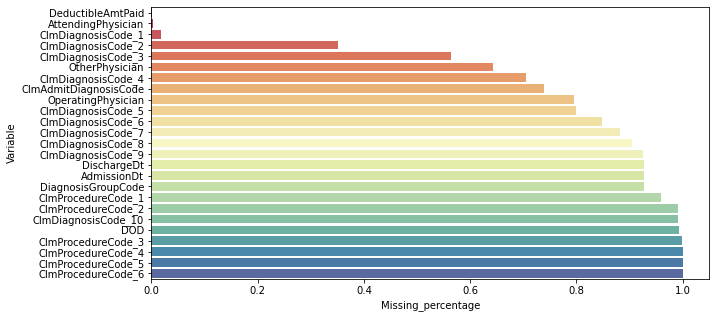

In [5]:
# missing value for each variables
def missing_percentage(df):
    nadf=(round(df.isna().sum().sort_values(ascending=True)/len(df),4)).reset_index()
    nadf.columns=['Variable','Missing_percentage']
    nadf=nadf[nadf['Missing_percentage']>0]

    if len(nadf)>0 :        
        fig, ax = plt.subplots(figsize=(10,5))
        sns.barplot(x='Missing_percentage',
               y='Variable',
               data=nadf,
               palette='Spectral')
    
    return nadf
train_na=missing_percentage(train)

In [6]:
train_na['Variable']

31        DeductibleAmtPaid
32       AttendingPhysician
33       ClmDiagnosisCode_1
34       ClmDiagnosisCode_2
35       ClmDiagnosisCode_3
36           OtherPhysician
37       ClmDiagnosisCode_4
38    ClmAdmitDiagnosisCode
39       OperatingPhysician
40       ClmDiagnosisCode_5
41       ClmDiagnosisCode_6
42       ClmDiagnosisCode_7
43       ClmDiagnosisCode_8
44       ClmDiagnosisCode_9
45              DischargeDt
46              AdmissionDt
47       DiagnosisGroupCode
48       ClmProcedureCode_1
49       ClmProcedureCode_2
50      ClmDiagnosisCode_10
51                      DOD
52       ClmProcedureCode_3
53       ClmProcedureCode_4
54       ClmProcedureCode_5
55       ClmProcedureCode_6
Name: Variable, dtype: object

In [7]:
codelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6','ClmAdmitDiagnosisCode','DiagnosisGroupCode']

amountlist=['DeductibleAmtPaid']

for col in codelist:
    train[col]=train[col].fillna('0')
    
for col in amountlist:
    train[col]=train[col].fillna(0)


train['ClaimStartDt']=pd.to_datetime(train['ClaimStartDt'], errors='coerce')
train['AdmissionDt']=pd.to_datetime(train['AdmissionDt'], errors='coerce')
train['DischargeDt']=pd.to_datetime(train['DischargeDt'], errors='coerce')
train['ClaimStartWeek']=train['ClaimStartDt'].dt.week
train['ClaimStartYear']=train['ClaimStartDt'].dt.year

train['TreatmentDuration']=np.where(train['Category']=='Inpatient',
                                    (train['DischargeDt']-train['AdmissionDt']).astype('timedelta64[D]').astype('int', errors='ignore'),
                                    0)

train['IsDead']=np.where(train['DOD'].isna(), 'No', 'Yes')

train['AdmissionDt'].fillna(train['ClaimStartDt'], inplace=True)
train['Age']=round((pd.to_datetime(train['AdmissionDt'])-pd.to_datetime(train['DOB'])).dt.total_seconds() / (24 * 60 * 60 * 365),1)

train.drop(['AdmissionDt','DischargeDt','DOD'],axis=1,inplace=True, errors='ignore')

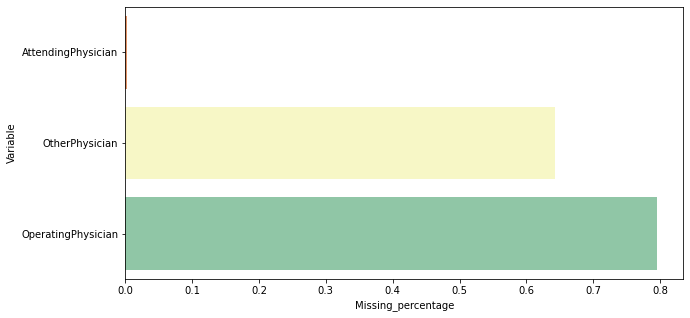

In [8]:
train_na=missing_percentage(train)

In [9]:
train_na

,Variable,Missing_percentage
55,AttendingPhysician,0.0027
56,OtherPhysician,0.6422
57,OperatingPhysician,0.7950


<h1 style="background-color:powderblue;">3. Fearture Engineering</h1>

### Chronic features

In [10]:
# Chronic
train = train.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

train['Chronic_number']=train[['ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke' ]].sum(axis=1)

train['Chronic']= np.where((train['Chronic_number'])>0, 'Yes', 'No')

#### Gender

In [11]:
train = train.replace({'Gender': 2}, 'Female')
train = train.replace({'Gender': 1}, 'Male')

### change numeric features to string

In [12]:
# numeric columns
def numeric_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','datetime64[ns]']
    df_numeric = df.select_dtypes(include=numerics)
    return df_numeric 

# object columns
def object_columns(df):
    objects = ['object']
    df_object = df.select_dtypes(include=objects)
    return df_object 

In [13]:
numeric_columns(train).nunique().sort_values(ascending=False)

IPAnnualReimbursementAmt           3004
OPAnnualReimbursementAmt           2078
OPAnnualDeductibleAmt               789
Age                                 761
InscClaimAmtReimbursed              438
ClaimStartDt                        398
County                              314
IPAnnualDeductibleAmt               147
ClaimStartWeek                       53
State                                52
TreatmentDuration                    36
DeductibleAmtPaid                    17
NoOfMonths_PartACov                  13
NoOfMonths_PartBCov                  13
Chronic_number                       12
Race                                  4
ChronicCond_IschemicHeart             2
ChronicCond_Osteoporasis              2
ChronicCond_rheumatoidarthritis       2
ChronicCond_stroke                    2
ChronicCond_Depression                2
ChronicCond_ObstrPulmonary            2
ChronicCond_Cancer                    2
ChronicCond_KidneyDisease             2
ChronicCond_Heartfailure              2


In [14]:
def cat_features(df, ls):
    for l in ls:
        df[l]=df[l].astype(str)
    return df

catogry_fns=['Gender', 'Race', 'State', 'County', 
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'ClaimStartWeek', 'ClaimStartYear']
cat_features(train, catogry_fns)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,DOB,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Category,DiagnosisGroupCode,PotentialFraud,ClaimStartWeek,ClaimStartYear,TreatmentDuration,IsDead,Age,Chronic_number,Chronic
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,56409,1936-09-01,Female,1,0,39,280,12,12,0,0,0,0,0,0,0,0,0,0,0,0,0,30,50,Outpatient,0,Yes,41,2009,0.0,No,73.2,0,No
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,79380,1936-08-01,Male,1,0,52,590,12,12,1,0,0,0,0,0,0,1,0,0,0,0,0,90,40,Outpatient,0,No,7,2009,0.0,No,72.6,2,Yes
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1936-08-01,Male,1,0,52,590,12,12,1,0,0,0,0,0,0,1,0,0,0,0,0,90,40,Outpatient,0,No,26,2009,0.0,No,73.0,2,Yes
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1922-07-01,Male,1,0,39,270,12,12,1,1,0,0,0,0,1,1,1,1,0,0,0,1810,760,Outpatient,0,Yes,2,2009,0.0,No,86.6,6,Yes
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,0,0,0,0,0,0,0,0,0,0,0.0,71947,1922-07-01,Male,1,0,39,270,12,12,1,1,0,0,0,0,1,1,1,1,0,0,0,1810,760,Outpatient,0,Yes,4,2009,0.0,No,86.6,6,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000,PHY345332,PHY319565,NaN,2851,2762,53550,V0254,V1005,5173,79092,70704,2869,4148,9904.0,0,0,0,0,0,1068.0,2859,1956-12-01,Female,2,0,21,160,12,12,0,0,0,0,0,0,0,1,0,1,0,11400,2136,520,280,Inpatient,812,Yes,40,2009,4.0,No,52.9,2,Yes
558207,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000,PHY342806,PHY365497,NaN,42823,4148,4019,3970,4241,V1042,49122,4254,5990,0,8605.0,0,0,0,0,0,1068.0,79902,1953-10-01,Female,1,0,33,700,12,12,0,1,0,0,1,0,0,1,0,0,0,4000,1068,0,0,Inpatient,228,No,45,2009,3.0,No,56.1,3,Yes
558208,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000,PHY423220,PHY332752,NaN,4280,3963,5859,4019,40390,4111,71534,71590,V4502,0,9390.0,0,0,0,0,0,1068.0,78605,1919-09-01,Female,1,Y,45,910,12,12,1,1,1,0,1,1,1,1,1,1,0,8000,2136,1920,400,Inpatient,302,Yes,47,2009,4.0,No,90.3,9,Yes
558209,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000,PHY353156,NaN,NaN,7802,5859,496,2809,V1254,42822,4263,0414,41400,0,0,0,0,0,0,0,1068.0,7802,1919-09-01,Female,1,Y,45,910,12,12,1,1,1,0,1,1,1,1,1,1,0,8000,2136,1920,400,Inpatient,309,Yes,51,2009,1.0,No,90.4,9,Yes


### Age Groups

In [15]:
train['Age_group'] = pd.cut(train['Age'],
                     bins=[0,25, 35, 45,55,65,75,85,90,100,120],
                     labels=['<25','25-35','35-45','45-55','55-65','65-75','75-85','85-90','95-100','>100'],
                     right=False)

### Summary features

In [16]:
train['AnnualReimbursementAmt']=train['IPAnnualReimbursementAmt'] + train['OPAnnualReimbursementAmt']
train['AnnualDeductibleAmt']=train['IPAnnualDeductibleAmt'] + train['OPAnnualDeductibleAmt']

<h1 style="background-color:powderblue;">4. Explorary Data Analysis</h1>

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Functions</h1>

In [17]:
def color_list(n):
    chars = '0123456789ABCDEF'
    return ['#'+''.join(sample(chars,6)) for i in range(n)]

In [18]:
def annote_bars(df, feature, feature_number, hue_feature=None, note_type='count',ax=None):
    i=0
    for p in ax.patches:
        if hue_feature==None:
            total=len(df[feature])
        else:
            total=df.groupby([feature])[hue_feature].count()[i]            
        if note_type=='count':
            note='{:}'.format( p.get_height())
        elif note_type=='percentage':
            note='{:.1f}%'.format(100 * p.get_height()/total)
        else:
            note = '{:}'.format( p.get_height())+' ('+'{:.1f}%'.format(100 * p.get_height()/total)+')'
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(note, (x, y),ha='center')   
        i=(i+1)%feature_number

In [19]:
def annote_bars1(df, feature, feature_number, hue_feature=None, note_type='count', ax=None, sorterindex=None):
    i=0
    print(sorterindex[i])
    for p in ax.patches:
        if hue_feature==None:
            total=len(df[feature])
        else:
            total=df.groupby([feature])[hue_feature].count().loc[str(sorterindex[i])]
            
        
        if note_type=='count':
            note='{:}'.format( p.get_height())
        elif note_type=='percentage':
            note='{:.1f}%'.format(100 * p.get_height()/total)
        else:
            note = '{:}'.format( p.get_height())+' ('+'{:.1f}%'.format(100 * p.get_height()/total)+')'
         
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(note, (x, y),ha='center')   
        i=(i+1)%feature_number

In [20]:
def summary_venn(df, feature, condition,title=None):
    
    df_all=df[feature].unique()
    value1=df[condition].unique()[0]
    value2=df[condition].unique()[1]
    df_value1=df[df[condition]==value1][feature].unique()
    df_value2=df[df[condition]==value2][feature].unique()
    df_both=np.intersect1d(df_value1,df_value2)

    count_all=len(df_all)
    count_value1=len(df_value1)
    count_value2=len(df_value2)
    count_both=count_value1+count_value2-count_all
    
    cl=color_list(3)    

    print('Number of '+feature+' (total) : ', 
          str(count_all))
    print('Nuber of '+feature+' ('+value1+' Only) : ', 
          str(count_value1-count_both)+' (' f"{((count_value1-count_both)/count_all):1.1%}" +' )')
    print('Nuber of '+feature+' ('+value2+' Only) : ', 
          str(count_value2-count_both)+' (' f"{((count_value2-count_both)/count_all):1.1%}" +' )')
    print('Number of '+feature+' (Both):', 
          str(count_both)+' (' f"{((count_both)/count_all):1.1%}" +' )')

    labels_depts=[feature+' \n ('+value1+')',
                  feature+' \n ('+value2+')']
    v1 = venn2(
        [set(df_value1), set(df_value2)],
        set_labels=labels_depts,
        set_colors=[cl[0], cl[1]],
        subset_label_formatter=lambda x: str(x)+'\n (' f"{(x/count_all):1.1%}" +')'
    )
    if v1.get_patch_by_id('11')!=None:
        v1.get_patch_by_id('11').set_color(cl[2])
    plt.title(title)

    plt.show()

In [21]:
def uni_distplot(df, feature):

    fig = plt.figure(constrained_layout=True, figsize=(12,6))
    grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    
    ax1 = fig.add_subplot(grid[0,:])
    ax1.set_title('Histogram')
    sns.histplot(df[feature], discrete=True, ax = ax1)

    ax2 = fig.add_subplot(grid[1, 0])
    ax2.set_title('Box Plot')
    sns.boxplot(y=df[feature], color='green', ax = ax2 )
    
    
    ax3 = fig.add_subplot(grid[1, 1])
    ax3.set_title('Violin Plot')
    sns.violinplot( y = df[feature], color='yellow' , ax=ax3)

In [22]:
def bi_distplot(df, cat_feature=None, num_feature=None, hue=None):

    fig = plt.figure(constrained_layout=True, figsize=(12,4))
    grid = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    
    ax1 = fig.add_subplot(grid[0, 0])
    ax1.set_title('Histogram Plot for '+cat_feature)    
    sns.countplot(cat_feature,  data=df, ax=ax1)  
        
    
    ax2 = fig.add_subplot(grid[0, 1])
    ax2.set_title('Box Plot for ' + cat_feature+' and '+ num_feature)
    sns.boxplot(x =cat_feature, y =num_feature, data = df, ax=ax2)
        
    ax3 = fig.add_subplot(grid[0, 2])
    ax3.set_title('Box Plot for '+cat_feature+' and '+ num_feature)
    sns.violinplot(x = cat_feature, y = num_feature , data=df, ax=ax3)
    
    n=df[cat_feature].nunique()
    
    annote_bars(df, cat_feature, n, hue_feature=None, note_type='count_percentage',ax=ax1)

    plt.show()

In [23]:
def plotting_3_chart(df, feature, ylim=2000):

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,4))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, 0])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)
    
    skewness=round(df[feature].skew(),4)
    Kurtosis=round(df[feature].kurt(),4)
    
    if (skewness>0.5) | (skewness<-0.5):
        cs='red'
    else:
        cs='green'
        
    if (Kurtosis>3) |(Kurtosis<-2):
        ck='red'
    else:
        ck='green'
        
    skew_patch = mpatches.Patch(color=cs, label=skewness)
    plt.legend(handles=[skew_patch])
    Kurtosis_patch = mpatches.Patch(color=ck, label=skewness)
    plt.legend(handles=[Kurtosis_patch])
    
    colors = [cs, ck]    
    texts = [skewness, Kurtosis]
    patchList = []
    for i in range(len(texts)):
        data_key = mpatches.Patch(facecolor=colors[i][0], label=texts[i])
        patchList.append(data_key)

    plt.gca()
    plt.legend(handles=patchList,ncol=len(patchList), fontsize='small')
    
    
    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[0, 1])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[0, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(y=df.loc[:,feature], ax = ax3 )
    ax3.set_ylim([0, ylim])

    log_feature=np.log1p(df[feature])
    ax4 = fig.add_subplot(grid[1, 0])
    ## Set the title. 
    ax4.set_title('Log Normal Histogram')
    ax4.set_xlabel('Log '+feature)
    ## plot the log-scaled histogram. 
    sns.distplot(log_feature, norm_hist=True, ax = ax4)
    
    skewness=round(log_feature.skew(),4)
    Kurtosis=round(log_feature.kurt(),4)
    
    if (skewness>0.5) | (skewness<-0.5):
        cs='red'
    else:
        cs='green'
        
    if (Kurtosis>3) |(Kurtosis<-2):
        ck='red'
    else:
        ck='green'
        
    skew_patch = mpatches.Patch(color=cs, label=skewness)
    plt.legend(handles=[skew_patch])
    Kurtosis_patch = mpatches.Patch(color=ck, label=skewness)
    plt.legend(handles=[Kurtosis_patch])
    
    colors = [cs, ck]    
    texts = [skewness, Kurtosis]
    patchList = []
    for i in range(len(texts)):
        data_key = mpatches.Patch(facecolor=colors[i][0], label=texts[i])
        patchList.append(data_key)

    plt.gca()
    plt.legend(handles=patchList,ncol=len(patchList), fontsize='small')
    
    # customizing the QQ_plot. 
    ax5 = fig.add_subplot(grid[1, 1])
    ## Set the title. 
    ax5.set_title('Log Normal QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(log_feature, plot = ax5)

    ## Customizing the Box Plot. 
    ax6 = fig.add_subplot(grid[1, 2])
    ## Set title. 
    ax6.set_title('Log Normal Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(y=log_feature, ax = ax6 )
    plt.show()

In [24]:
def resources_plot(df, feature, xtop=-100, ytop=10000):
    fig = plt.figure(constrained_layout=True, figsize=(12,20))

    grid = gridspec.GridSpec(ncols=2, nrows=5, figure=fig)

    ax00 = fig.add_subplot(grid[0, 0])
    ax00.set_title(feature + ' Distribution')
    sns.distplot(x=df[feature], norm_hist=True, ax = ax00)
    
    ax01 = fig.add_subplot(grid[0, 1])
    ax01.set_title(feature + ' Distribution')
    sns.boxplot(y=df[feature], ax = ax01)
    ax01.set_ylim(-100,ytop)
    
    ax10 = fig.add_subplot(grid[1, 0])
    ax10.set_title(feature + ' for Potential Fraud')
    sns.boxplot(x='PotentialFraud', y=feature, palette="Set3", data=df, ax=ax10)
    ax10.set_ylim(-100,ytop)
    
    ax10 = fig.add_subplot(grid[1, 1])
    ax10.set_title(feature + ' for Inpatient / Outpatient')
    sns.boxplot(x='Category', y=feature, palette="Set3", data=df, ax=ax10)
    ax10.set_ylim(-100,ytop)
    
    ax20 = fig.add_subplot(grid[2, :])
    ax20.set_title(feature + ' for Inpatient / Outpatient by Potential Fraud')
    sns.boxplot(x='Category', y=feature, palette="Set3", hue='PotentialFraud', data=df, ax=ax20)
    ax20.set_ylim(-100,ytop)
    
    ax30 = fig.add_subplot(grid[3, :])
    ax30.set_title(feature + ' for Age Groups')
    sns.boxplot(x='Age_group', y=feature, palette="Set3",data=df, ax=ax30)
    ax30.set_ylim(-100,ytop)
    
    ax40 = fig.add_subplot(grid[4, :])
    ax40.set_title(feature + ' for Age Groups by Potential Fraud')
    sns.boxplot(x='Age_group', y=feature, palette="Set3", hue='PotentialFraud', data=df, ax=ax40)
    ax40.set_ylim(-100,ytop)
    
    plt.show()
    
    print('-----------------------------------------------------')
    print('The statistics of '+feature+': ')
    print('-----------------------------------------------------')
    display(resources[feature].describe(include='all'))
    
    print('-----------------------------------------------------')
    print('The correlations of '+feature +' and other resources: ')
    print('-----------------------------------------------------')
    cor=(resources.corr()**2)[feature].sort_values(ascending=False).to_frame() 
    display(cor.sort_values(feature,ascending=False))
    
    import statsmodels.api as sm
    from statsmodels.formula.api import ols

    # Ordinary Least Squares (OLS) model
    model = ols(feature+' ~ C(PotentialFraud)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print('-----------------------------------------------------')
    print('The P value for '+feature +' between PotentialFraud (Yes/No)')
    print('-----------------------------------------------------')
    display(anova_table)    
    
    model = ols(feature+' ~ C(Category)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print('-----------------------------------------------------')
    print('The P value for '+feature +' between Inpatient / Outpatient')
    print('-----------------------------------------------------')
    display(anova_table)
    
    model = ols(feature+' ~ C(Age_group)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print('-----------------------------------------------------')
    print('The P value for '+feature +' among Age Groups')
    print('-----------------------------------------------------')
    display(anova_table)
    
    
    def style_sig(v, props=''):
        return props if (v < 0.05) and (v > 0) else None
    
    from bioinfokit.analys import stat
    res = stat()
    res.tukey_hsd(df=df, res_var=feature, xfac_var='Age_group', 
                  anova_model=feature+' ~ C(Age_group)') 
    print('-----------------------------------------------------')
    print('The P value for '+feature +' among Age Groups')  
    print('-----------------------------------------------------')
    display(res.tukey_summary)

    res = stat()
    res.tukey_hsd(df=df, res_var=feature, xfac_var=['PotentialFraud','Age_group'], 
                  anova_model=feature+' ~ C(PotentialFraud)+C(Age_group)')
    acs=res.tukey_summary
    s2 = acs.style.applymap(style_sig, props='color:red;background-color: yellow')
    print('-----------------------------------------------------')
    print('The P value for '+feature +' among different Age Groups and Potential Fraud (Yes/No)')  
    print('-----------------------------------------------------')
    display(acs)
#     display(s2)
    
    res = stat()
    res.tukey_hsd(df=df, res_var=feature, xfac_var=['PotentialFraud','Category'], 
                  anova_model=feature+' ~ C(PotentialFraud)+C(Category)')
    acs=res.tukey_summary
    s2 = acs.style.applymap(style_sig, props='color:red;background-color: yellow')
    print('-----------------------------------------------------')
    print('The P value for '+feature +' among different Age Groups and Inpatient / Outpatient claims')  
    print('-----------------------------------------------------')
    display(acs)
#     display(s2)

In [25]:
def correlations(data1,data2):
    df=pd.DataFrame()
    l1=[]
    l2=[]
    l1.append(mean(data1))
    l1.append(std(data1))
    l2.append(mean(data2))
    l2.append(std(data2))
    
#     # calculate covariance matrix
#     # cov(X, Y) = (sum (x - mean(X)) * (y - mean(Y)) ) * 1/(n-1)
#     covariance = cov(data1, data2)
#     l1.append(covariance)
#     l2.append(covariance)
    
    # calculate Pearson's correlation
    # Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
    corr_pearson, _ = pearsonr(data1, data2)
    l1.append(corr_pearson)
    l2.append(corr_pearson)

    # calculate spearman's correlation
    # Spearman's correlation coefficient = covariance(rank(X), rank(Y)) / (stdv(rank(X)) * stdv(rank(Y)))
    corr_spearman, _ = spearmanr(data1, data2)
    l1.append(corr_spearman)
    l2.append(corr_spearman)
    
    df['D1']=l1
    df['D2']=l2
    
    df['index']=['Mean','Std','Pearson_corr','Spearmans_corr']
    df.set_index('index',inplace=True)
    return df



In [26]:
def bi_plot_numeric(df, col1, col2, sample=0.1):
    if (sample != None):
        df=df.sample(frac =sample)
        
    df_cor=correlations(df[col1],df[col2])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    # histgram for col1
    sns.histplot(data=df, x=col1, kde=True, ax=ax1)
#     ax1.scatter(x=df[col1], y=df[col2], data=df, ax=ax1) 
    ax1.set_title='Distribution plot for '+col1
    ax1.set_xlabel(col1)
    
    # histgram for col2
    sns.histplot(data=df, x=col2, kde=True, ax=ax2)
#     ax1.scatter(x=df[col1], y=df[col2], data=df, ax=ax1) 
    ax2.set_title='Distribution plot for '+col2
    ax2.set_xlabel(col2)
    
    # scatter plot for col1 and col2
    sns.scatterplot(data=df, x=col1, y=col2, ax=ax3)
#     ax3.scatter(x=df[col1], y=df[col2], data=df, ax=ax1) 
    ax3.set_title='Scatter plot for '+col1+' vs. '+col2
    ax3.set_xlabel(col1)
    ax3.set_ylabel(col2)
    
    # contour plot for col1 and col2
    sns.kdeplot(x=col1, y=col2, data=df, cmap="Blues", shade=True, thresh=0, ax=ax4)
#     cp=ax4.tricontour(X, Y, Z) 
#     fig.colorbar(cp) # Add a colorbar to a plot
    ax4.set_title='Contour plot for '+col1+' vs. '+col2
    ax4.set_xlabel(col1)
    ax4.set_ylabel(col2)

    custom_lines = [Line2D([0], [0], color='blue', lw=4),]
    ax1.legend(custom_lines, ['Mean of '+col1+': '+str(df_cor.loc['Mean'][0]),
                             ])
    ax2.legend(custom_lines, ['Mean of '+col2+': '+str(df_cor.loc['Mean'][1]),
                             ])
    ax3.legend(custom_lines, ['Correlation coefficient : '+str(df_cor.loc['Spearmans_corr'][0]),
                             ])
    ax4.legend(custom_lines, ['Correlation coefficient : '+str(df_cor.loc['Spearmans_corr'][0]),
                             ])
    
    plt.show()

In [27]:
def bar_by_category(df, x, y, category, title=''):
    
    def custom_palette(df, feature, category, cl=['m','y','b']): 
        palette={}
        for p, f in  zip(df[feature], df[category]):
            if f == 'Yes':
                palette[p] = cl[0]
            elif f== 'No':
                palette[p] = cl[1]
            else:
                palette[p] = cl[2]

        return palette   
    
    cl=color_list(3)
    

    plt.figure(figsize=(15,5))
    ax = sns.barplot(x = x, y = y,
                     data = df,
                     palette=custom_palette(df, x, category, cl))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.set_title('')

    yes_patch = mpatches.Patch(color=cl[0], label='Potential Fraud')
    no_patch = mpatches.Patch(color=cl[1], label='No Potential Fraud')
    both_patch = mpatches.Patch(color=cl[2], label='Both')
    
    plt.title(title)

    plt.legend(handles=[yes_patch, no_patch, both_patch])

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Data Summary</h1>

In [28]:
physicians=pd.melt(train[['BeneID', 'ClaimID', 'Provider', 'Category',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'PotentialFraud']], 
        id_vars=['BeneID','ClaimID', 'Provider','PotentialFraud','Category'], 
        value_vars=train[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], 
        var_name='Type', 
        value_name='Physician').sort_values(by=['ClaimID','Type']).dropna(subset=['Physician'])

#### Claims

Number of ClaimID (total) :  558211
Nuber of ClaimID (Outpatient Only) :  517737 (92.7% )
Nuber of ClaimID (Inpatient Only) :  40474 (7.3% )
Number of ClaimID (Both): 0 (0.0% )


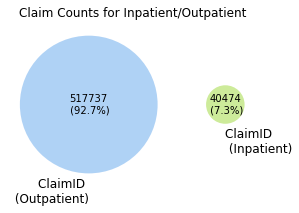

In [30]:
summary_venn(train, 'ClaimID', 'Category', 
             title='Claim Counts for Inpatient/Outpatient')

Number of ClaimID (total) :  558211
Nuber of ClaimID (Yes Only) :  212796 (38.1% )
Nuber of ClaimID (No Only) :  345415 (61.9% )
Number of ClaimID (Both): 0 (0.0% )


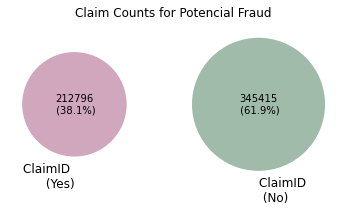

In [31]:
summary_venn(train, 'ClaimID', 'PotentialFraud', 
             title='Claim Counts for Potencial Fraud')

#### Providers

Number of Provider (total) :  5410
Nuber of Provider (Outpatient Only) :  3318 (61.3% )
Nuber of Provider (Inpatient Only) :  398 (7.4% )
Number of Provider (Both): 1694 (31.3% )


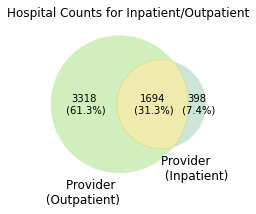

In [32]:
summary_venn(train, 'Provider', 'Category', 
             title='Hospital Counts for Inpatient/Outpatient')

Number of Provider (total) :  5410
Nuber of Provider (Yes Only) :  506 (9.4% )
Nuber of Provider (No Only) :  4904 (90.6% )
Number of Provider (Both): 0 (0.0% )


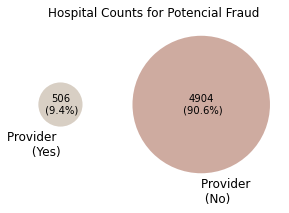

In [33]:
summary_venn(train, 'Provider', 'PotentialFraud', 
             title='Hospital Counts for Potencial Fraud')

#### Physicians

Number of Physician (total) :  100737
Nuber of Physician (Outpatient Only) :  82481 (81.9% )
Nuber of Physician (Inpatient Only) :  10967 (10.9% )
Number of Physician (Both): 7289 (7.2% )


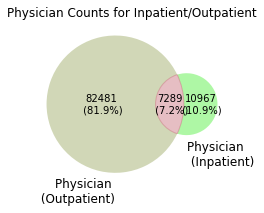

In [34]:
df=physicians.drop('Type', axis=1).drop_duplicates().groupby(['Physician','Category']).count().reset_index()

summary_venn(df, 'Physician', 'Category', 
             title='Physician Counts for Inpatient/Outpatient')

Number of Physician (total) :  100737
Nuber of Physician (No Only) :  74509 (74.0% )
Nuber of Physician (Yes Only) :  23821 (23.6% )
Number of Physician (Both): 2407 (2.4% )


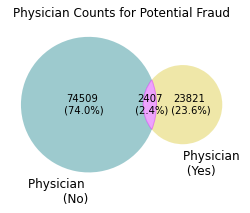

In [35]:
df=physicians.drop('Type', axis=1).drop_duplicates().groupby(['Physician','PotentialFraud']).count().reset_index()

summary_venn(df, 'Physician', 'PotentialFraud', 
             title='Physician Counts for Potential Fraud')

#### Patients

Number of BeneID (total) :  138556
Nuber of BeneID (Outpatient Only) :  107267 (77.4% )
Nuber of BeneID (Inpatient Only) :  4576 (3.3% )
Number of BeneID (Both): 26713 (19.3% )


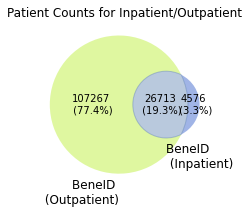

In [36]:
summary_venn(train, 'BeneID', 'Category', 
             title='Patient Counts for Inpatient/Outpatient')

Number of BeneID (total) :  138556
Nuber of BeneID (Yes Only) :  24929 (18.0% )
Nuber of BeneID (No Only) :  54559 (39.4% )
Number of BeneID (Both): 59068 (42.6% )


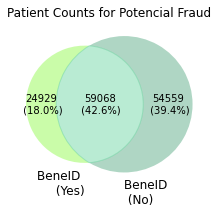

In [37]:
summary_venn(train, 'BeneID', 'PotentialFraud', 
             title='Patient Counts for Potencial Fraud')

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Providers</h1>

#### Potential Frauds

In [52]:
providers=train[['BeneID', 'ClaimID', 'Provider', 'Category',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'PotentialFraud']]

Total number of providers: 5410


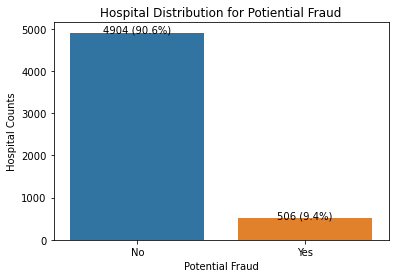

In [53]:
df=providers[['PotentialFraud','Provider']].drop_duplicates()
plt.figure(figsize=(6,4))
ax=sns.countplot(x = 'PotentialFraud',
            data = df,
            order = df['PotentialFraud'].value_counts().index.sort_values())

ax.set_ylabel('Hospital Counts')
ax.set_xlabel('Potential Fraud')
ax.set_title('Hospital Distribution for Potiential Fraud')

annote_bars(df, 'PotentialFraud', 2, hue_feature=None, note_type='count_percentage', ax=ax)
print('Total number of providers:' , df['Provider'].nunique())

Text(0.5, 1.0, 'Provider distribution for Potential Fraud')

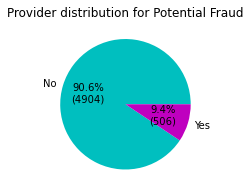

In [54]:
df=providers[['PotentialFraud','Provider']].drop_duplicates()

total=df['Provider'].nunique()

def piecount(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.pie(
    df.groupby('PotentialFraud')['Provider'].count(), 
    labels = ['No', 'Yes'], autopct=lambda pct: piecount(pct, total), colors=['c', 'm'])
plt.title('Provider distribution for Potential Fraud')

<div class="alert-warning">
    <b>Findings: </b> 
    <li> <font color='red'>There are 5410 providers collected</font> </li>
    <li> <font color='red'>4904 or 90.6% of them are not suspective potential Frauds. </font> </li>
    <li> <font color='red'>506 of 9.4% of them are suspective potential Frauds. </font> </li>
</div>

#### Physician

In [55]:
physicians=pd.melt(train[['BeneID', 'ClaimID', 'Provider', 'Category',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'PotentialFraud']], 
        id_vars=['BeneID','ClaimID', 'Provider','PotentialFraud','Category'], 
        value_vars=train[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], 
        var_name='Type', 
        value_name='Physician').sort_values(by=['ClaimID','Type']).dropna(subset=['Physician'])

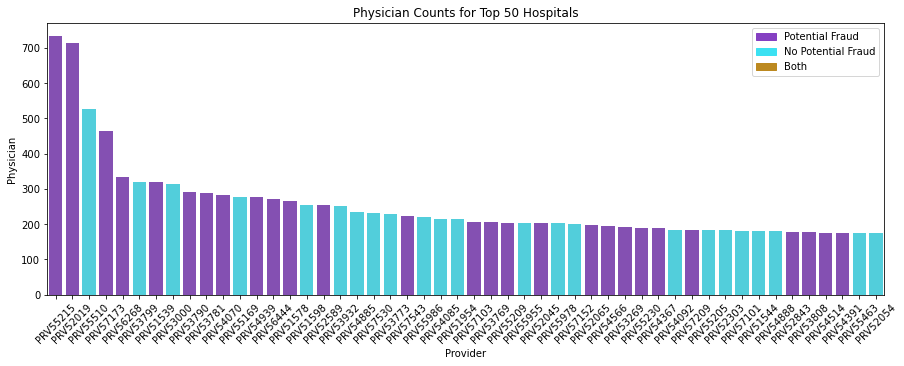

In [56]:
df=physicians[['Physician','Provider', 'PotentialFraud']].drop_duplicates() \
    .groupby(['Provider', 'PotentialFraud']).count().reset_index().sort_values(by='Physician', ascending=False)
top_provider=df.head(50)
bar_by_category(top_provider, 'Provider', 'Physician', 'PotentialFraud', title='Physician Counts for Top 50 Hospitals')


In [57]:
print( str(physicians['Physician'].nunique())+ ' physicians are collected')

100737 physicians are collected


In [58]:
df.describe()

,Physician
count,5410.000000
mean,20.210536
std,36.228770
min,1.000000
25%,2.000000
50%,7.000000
75%,23.000000
max,735.000000


#### Claim Counts for Hospitals

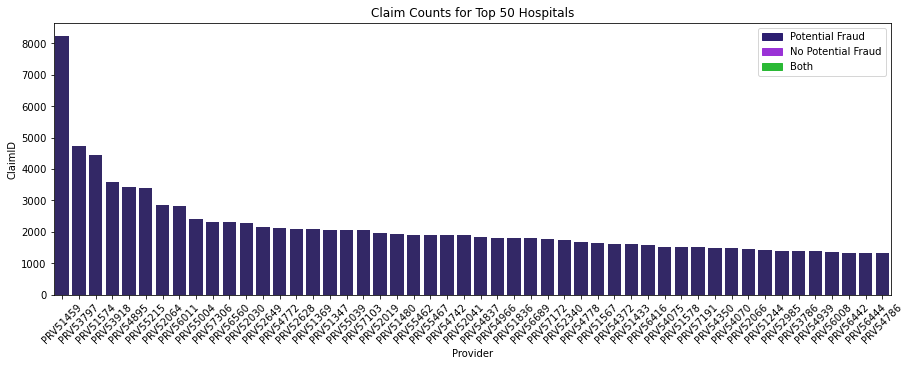

In [59]:
df=train[['ClaimID','Provider', 'PotentialFraud']].drop_duplicates() \
    .groupby(['Provider', 'PotentialFraud']).count().reset_index().sort_values(by='ClaimID', ascending=False)
top_provider=df.head(50)
bar_by_category(top_provider, 'Provider', 'ClaimID', 'PotentialFraud', title='Claim Counts for Top 50 Hospitals')


In [60]:
df.head(100)

,Provider,PotentialFraud,ClaimID
363,PRV51459,Yes,8240
2250,PRV53797,Yes,4739
455,PRV51574,Yes,4444
2335,PRV53918,Yes,3588
3113,PRV54895,Yes,3436
3363,PRV55215,Yes,3393
853,PRV52064,Yes,2844
4004,PRV56011,Yes,2833
3195,PRV55004,Yes,2399
5032,PRV57306,Yes,2315


In [61]:
df.index=range(len(df))
df[df['PotentialFraud']=='No']

,Provider,PotentialFraud,ClaimID
55,PRV53750,No,1245
58,PRV53871,No,1220
59,PRV53394,No,1215
60,PRV55552,No,1206
61,PRV52104,No,1189
...,...,...,...
5405,PRV56373,No,1
5406,PRV52221,No,1
5407,PRV55578,No,1
5408,PRV56377,No,1


<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>100737 physicians are collected </font> </li>
    <li> <font color='red'>The top 5 providers with most associated physicians are: 
['PRV55215',
 'PRV52019',
 'PRV55510',
 'PRV57173',
 'PRV56268']</font> </li>
    <li> <font color='red'>Provider 'PRV55215'has most physicians of 735.</font> </li>
    <li> <font color='red'>Both of the top two providers are suspects of Potential Frauds.</font> </li>
    <li> <font color='red'>Most providers have less than 300 associated physicians.</font> </li>
    <li> <font color='red'>Top hospitals with most Claim Acounts are all involved potential frauds</font> </li>
</div>

#### Inpatient/Outpatient

Number of ClaimID (total) :  558211
Nuber of ClaimID (Outpatient Only) :  517737 (92.7% )
Nuber of ClaimID (Inpatient Only) :  40474 (7.3% )
Number of ClaimID (Both): 0 (0.0% )


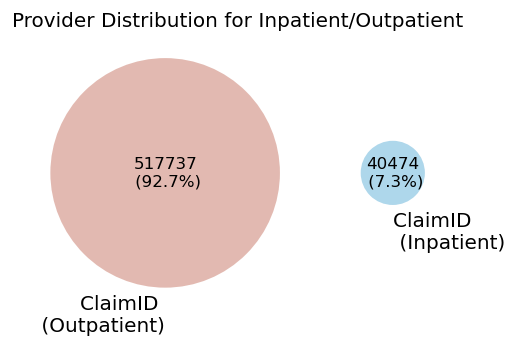

In [249]:
summary_venn(train, 'ClaimID', 'Category',
             title='Provider Distribution for Inpatient/Outpatient')

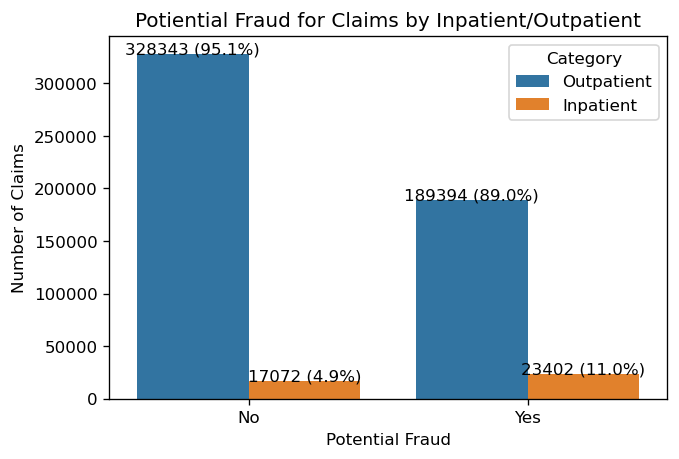

In [250]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x = 'PotentialFraud',
            hue='Category',
            data = providers,
            order = providers['PotentialFraud'].value_counts().index.sort_values())

ax.set_ylabel('Number of Claims')
ax.set_xlabel('Potential Fraud')
ax.set_title('Potiential Fraud for Claims by Inpatient/Outpatient')

annote_bars(providers, 'PotentialFraud', 2, hue_feature='Category', note_type='count_percentage', ax=ax)

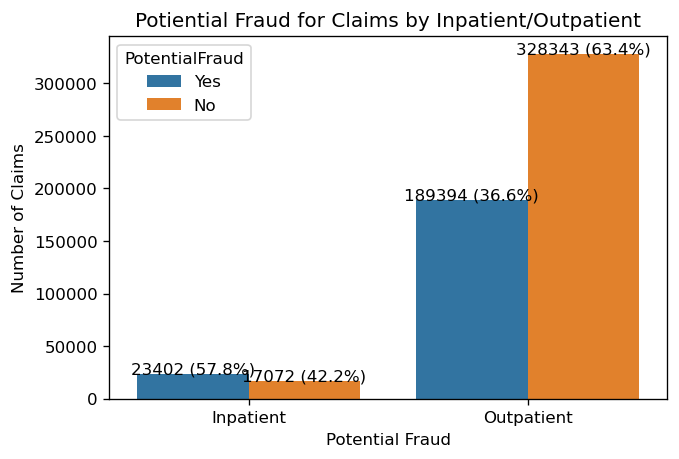

In [251]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x = 'Category',
            hue='PotentialFraud',
            data = providers,
            order = providers['Category'].value_counts().index.sort_values())

ax.set_ylabel('Number of Claims')
ax.set_xlabel('Potential Fraud')
ax.set_title('Potiential Fraud for Claims by Inpatient/Outpatient')

annote_bars(providers, 'Category', 2, hue_feature='PotentialFraud', note_type='count_percentage', ax=ax)

Number of Provider (total) :  5410
Nuber of Provider (Outpatient Only) :  3318 (61.3% )
Nuber of Provider (Inpatient Only) :  398 (7.4% )
Number of Provider (Both): 1694 (31.3% )


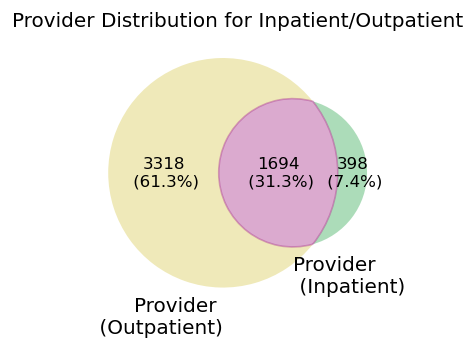

In [252]:
summary_venn(train, 'Provider', 'Category', 
             title='Provider Distribution for Inpatient/Outpatient')

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Number of Provider (total) :  5410</font> </li>
    <li> <font color='red'>Nuber of Provider (Inpatient Only) :  398</font> </li>
    <li> <font color='red'>Nuber of Provider (Outpatient Only) :  3318</font> </li>
    <li> <font color='red'>Number of Provider (Both): 1694</font> </li>
    <li> <font color='red'>The percentage of potential fraud are higher in inpatient claims than in outpatient claims</font> </li>
</div>

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Physicians</h1>

- Inpatient / Outpatient

In [63]:
physicians=pd.melt(train[['BeneID', 'ClaimID', 'Provider', 'Category',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'PotentialFraud']], 
        id_vars=['BeneID','ClaimID', 'Provider','PotentialFraud','Category'], 
        value_vars=train[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], 
        var_name='Type', 
        value_name='Physician').sort_values(by=['ClaimID','Type']).dropna(subset=['Physician'])

AttendingPhysician=physicians[physicians['Type']=='AttendingPhysician']
OperatingPhysician=physicians[physicians['Type']=='OperatingPhysician']
OtherPhysician=physicians[physicians['Type']=='AttendingPhysician']

df=physicians[['Physician','ClaimID','PotentialFraud']].groupby(['Physician','PotentialFraud']).count().reset_index()
df1=df[df['PotentialFraud']=='Yes'].sort_values(by='ClaimID', ascending=False)
df2=df[df['PotentialFraud']=='No'].sort_values(by='ClaimID', ascending=False)

df_all=pd.merge(df1, df2, on='Physician', how='outer')
df_all['IsPhysicianFraud']=np.where(df_all['PotentialFraud_x']=='Yes',
                                   np.where(df_all['PotentialFraud_y']=='No', 'Both', 'Yes'),'No')
df_all=df_all[['Physician','IsPhysicianFraud']]

Number of Physician (total) :  100737
Nuber of Physician (Outpatient Only) :  82481 (81.9% )
Nuber of Physician (Inpatient Only) :  10967 (10.9% )
Number of Physician (Both): 7289 (7.2% )


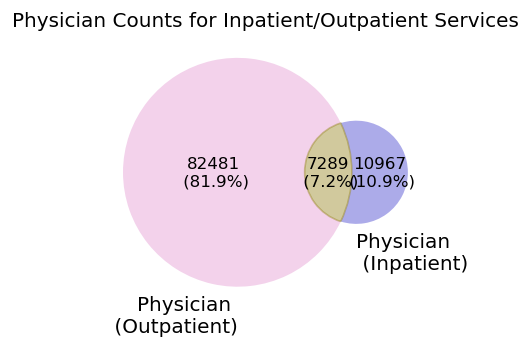

In [253]:
df=physicians.drop('Type', axis=1).drop_duplicates().groupby(['Physician','Category']).count().reset_index()

summary_venn(df, 'Physician', 'Category',
             title='Physician Counts for Inpatient/Outpatient Services')

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Number of Physician (total) :  100737</font> </li>
    <li> <font color='red'>Nuber of Physician (Inpatient Only) :  10967</font> </li>
    <li> <font color='red'>Nuber of Physician (Outpatient Only) :  82481</font> </li>
    <li> <font color='red'>Number of Physician (Both): 7289</font> </li>
    <li> <font color='red'></font> </li>
</div>

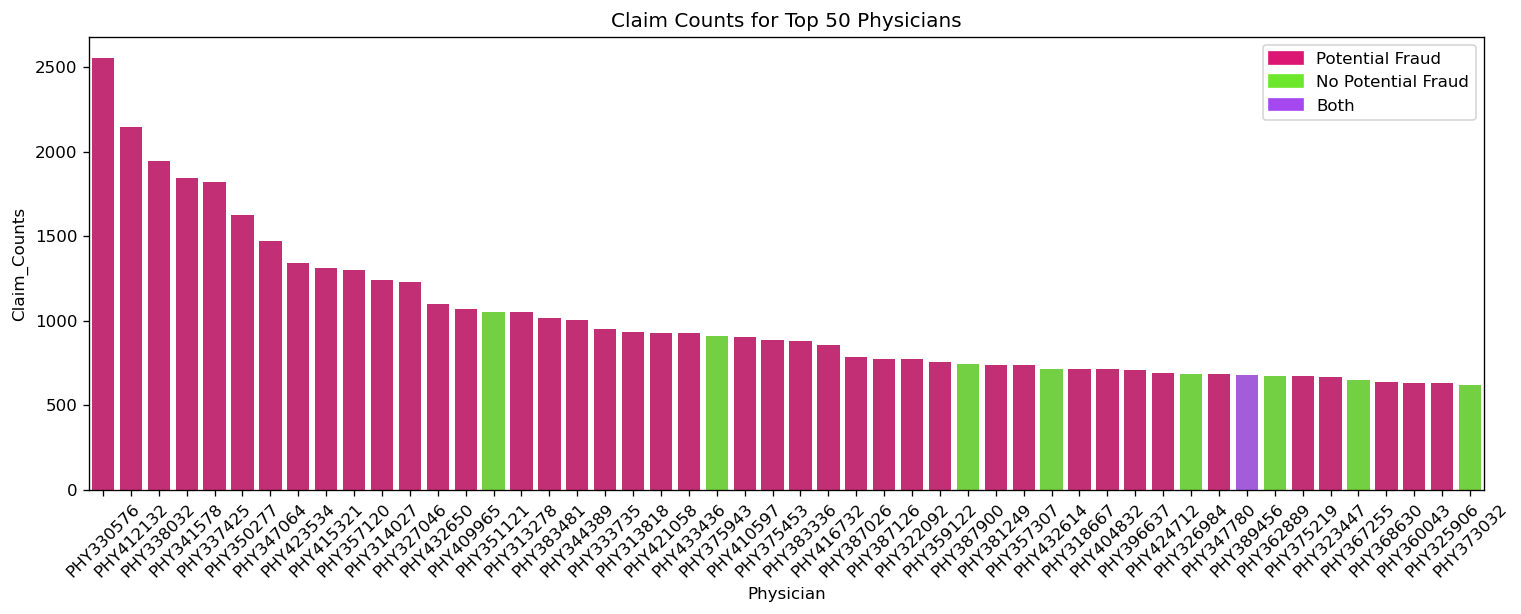

In [254]:
df=physicians[['ClaimID', 'Physician']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='ClaimID', ascending=False)
df.rename(columns={'ClaimID':'Claim_Counts'}, inplace=True)
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Claim_Counts', 'IsPhysicianFraud', 
                title='Claim Counts for Top 50 Physicians')


In [255]:
df.head().sort_values(by='Claim_Counts',ascending=False)

,Physician,Claim_Counts,IsPhysicianFraud
0,PHY330576,2552,Yes
1,PHY412132,2146,Yes
2,PHY338032,1947,Yes
3,PHY341578,1842,Yes
4,PHY337425,1821,Yes


<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>The top 5 physicians with most claims are: ['PHY330576', 'PHY412132', 'PHY338032', 'PHY341578', 'PHY337425']</font> </li>
    <li> <font color='red'>Physician 'PHY330576'has most Claims of 2552.</font> </li>
    <li> <font color='red'>'PHY330576' and 'PHY412132' have over 2000 claims.</font> </li>
    <li> <font color='red'>Most physicians have less than 1000 claims.</font> </li>
    <li> <font color='red'></font> </li>
</div>

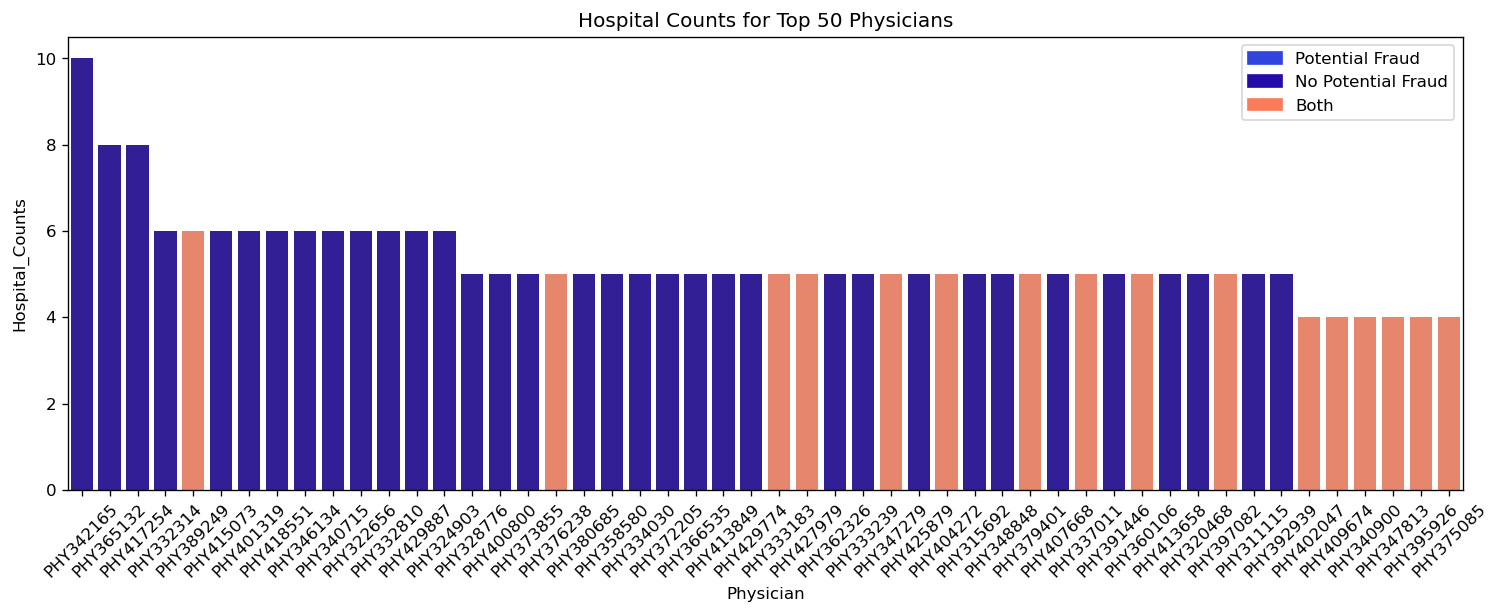

In [256]:
df=physicians[['Physician','Provider']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='Provider', ascending=False)
df=df.rename(columns={'Provider':'Hospital_Counts'})
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Hospital_Counts', 'IsPhysicianFraud', 
                title='Hospital Counts for Top 50 Physicians')

In [257]:
df.head()

,Physician,Hospital_Counts,IsPhysicianFraud
0,PHY342165,10,No
1,PHY365132,8,No
2,PHY417254,8,No
3,PHY332314,6,No
4,PHY389249,6,Both


<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>The top 5 physicians associated with most hospitals are: ['PHY342165', 'PHY365132', 'PHY417254', 'PHY332314', 'PHY389249']</font> </li>
    <li> <font color='red'>Physician 'PHY342165'has most associated hospitals of 10.</font> </li>
    <li> <font color='red'>Most physicians have less than 5 associated hospitals.</font> </li>
    <li> <font color='red'></font> </li>
</div>

- Attending Physicians

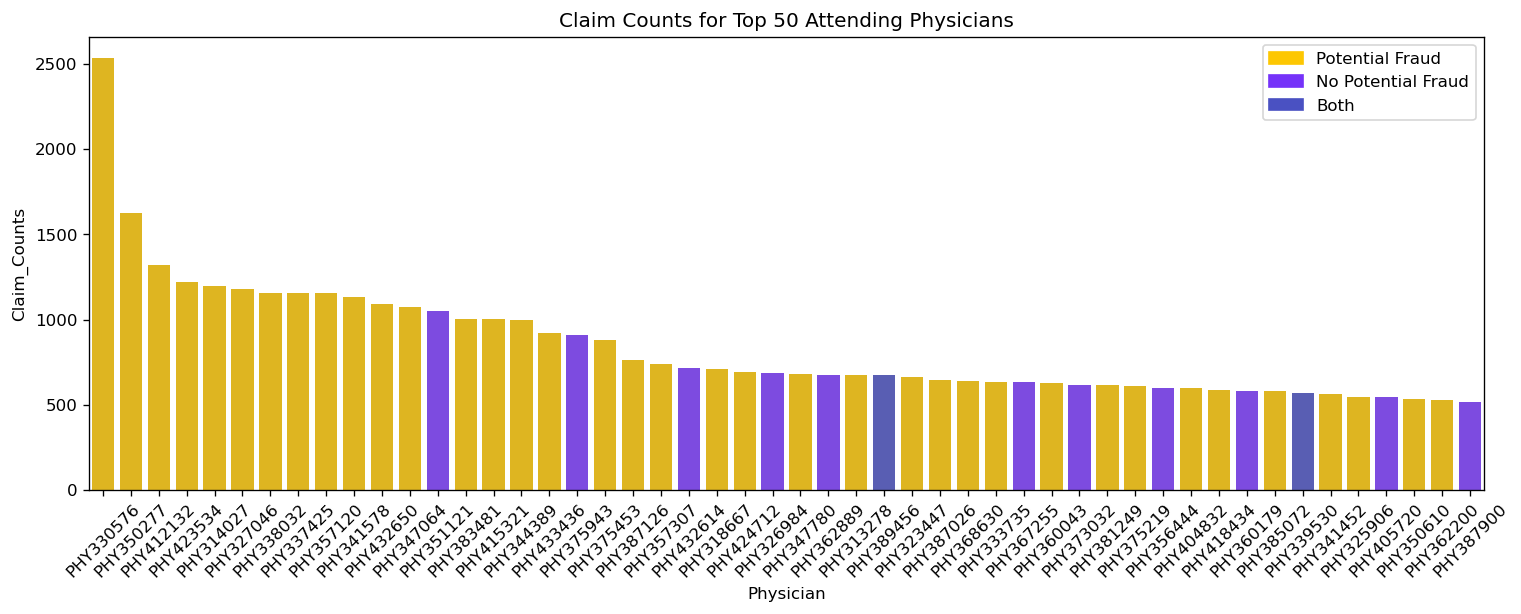

In [258]:
df=AttendingPhysician[['ClaimID', 'Physician']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='ClaimID', ascending=False)

df=df.rename(columns={'ClaimID':'Claim_Counts'})
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Claim_Counts', 'IsPhysicianFraud', 
                title='Claim Counts for Top 50 Attending Physicians')


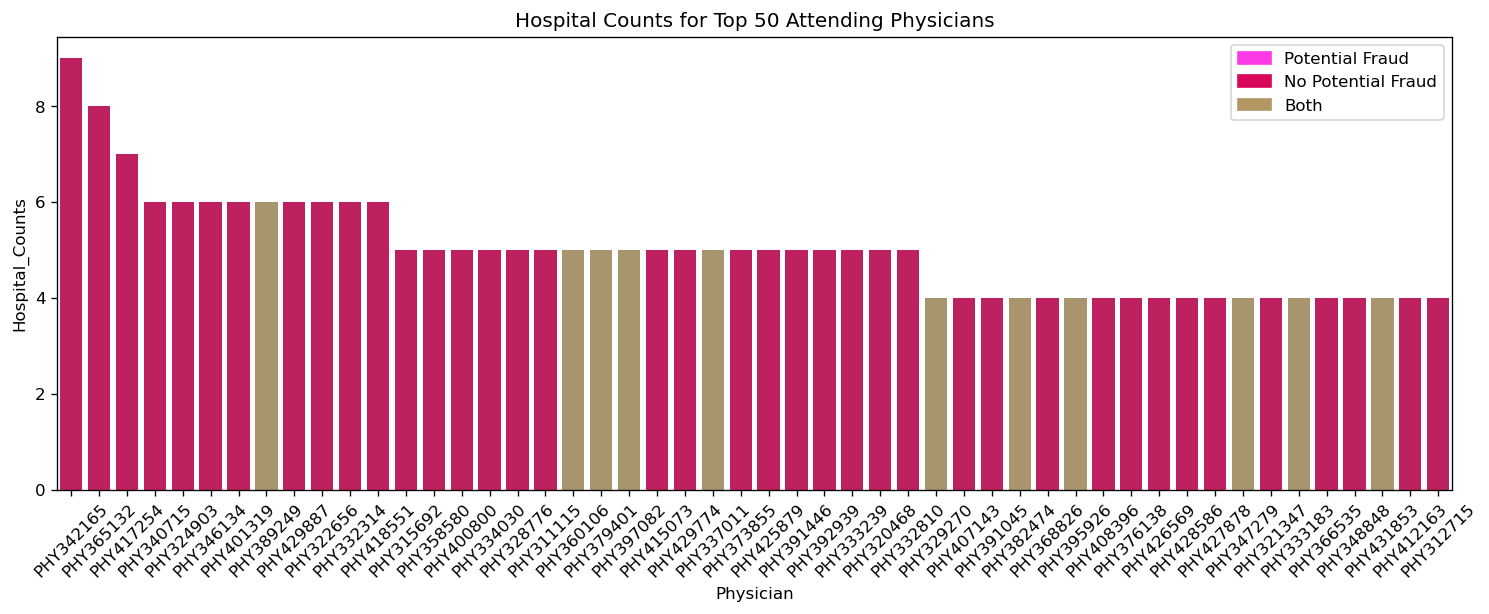

In [259]:
df=AttendingPhysician[['Physician','Provider']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='Provider', ascending=False)


df=df.rename(columns={'Provider':'Hospital_Counts'})
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Hospital_Counts', 'IsPhysicianFraud', 
                title='Hospital Counts for Top 50 Attending Physicians')



- Operating Physician

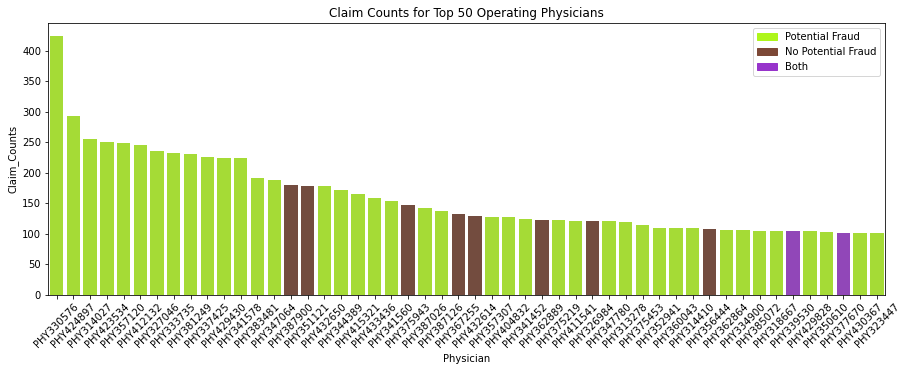

In [66]:
df=OperatingPhysician[['ClaimID', 'Physician']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='ClaimID', ascending=False)


df=df.rename(columns={'ClaimID':'Claim_Counts'})
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Claim_Counts', 'IsPhysicianFraud', 
                title='Claim Counts for Top 50 Operating Physicians')

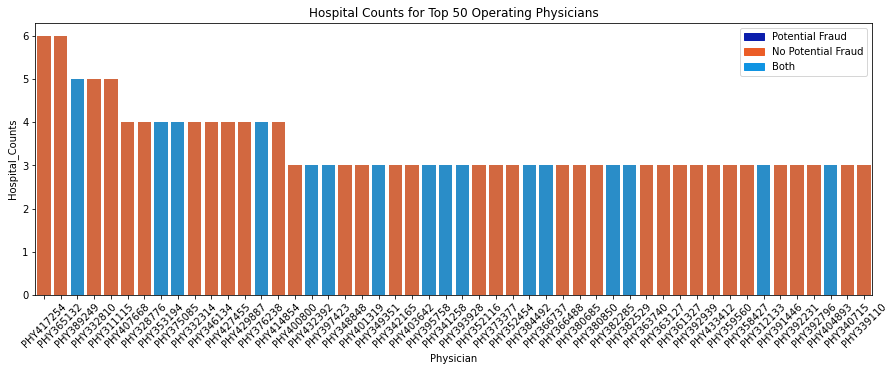

In [67]:
df=OperatingPhysician[['Physician','Provider']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='Provider', ascending=False)
df.rename(columns={'Provider':'Hospital_Counts'}, inplace=True)
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Hospital_Counts', 'IsPhysicianFraud', 
                title='Hospital Counts for Top 50 Operating Physicians')

- Other Physician

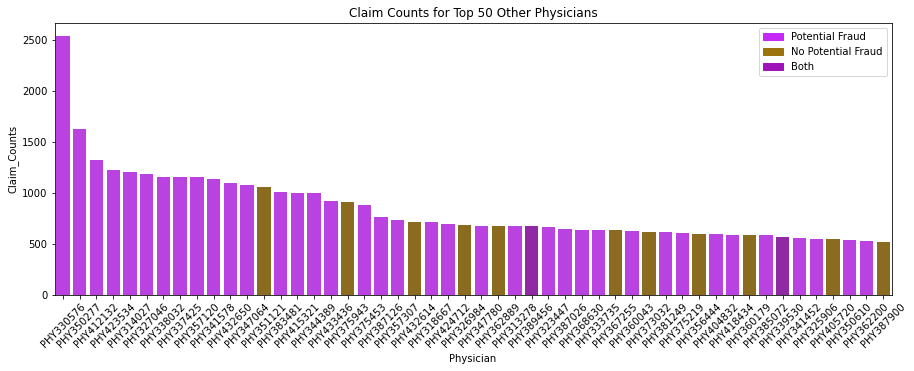

In [68]:
df=OtherPhysician[['ClaimID', 'Physician']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='ClaimID', ascending=False)

df.rename(columns={'ClaimID':'Claim_Counts'}, inplace=True)
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Claim_Counts', 'IsPhysicianFraud', 
                title='Claim Counts for Top 50 Other Physicians')

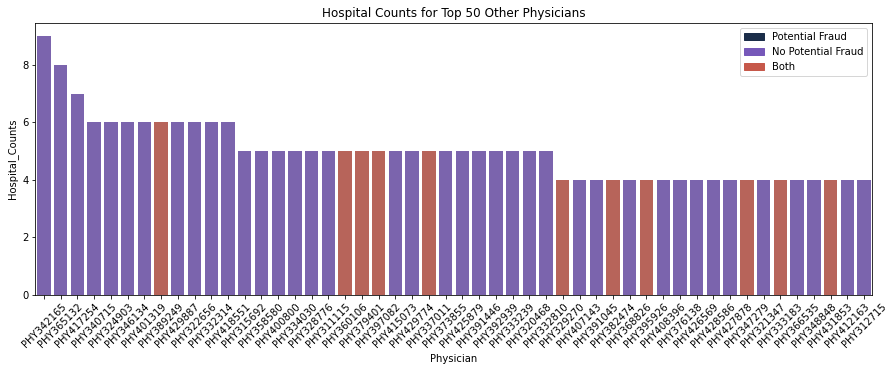

In [69]:
df=OtherPhysician[['Physician','Provider']].drop_duplicates().groupby('Physician').count().reset_index().sort_values(by='Provider', ascending=False)

df.rename(columns={'Provider':'Hospital_Counts'}, inplace=True)
df=pd.merge(df, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Hospital_Counts', 'IsPhysicianFraud', 
                title='Hospital Counts for Top 50 Other Physicians')

- Potiential Frauds

In [70]:
df=physicians[['ClaimID', 'Physician', 'Provider', 'PotentialFraud']].groupby(['Physician','PotentialFraud']).count().reset_index()

count_all=df['Physician'].nunique()
count_fraud=df[df['PotentialFraud']=='Yes']['Physician'].nunique()
count_no_fraud=df[df['PotentialFraud']=='No']['Physician'].nunique()
count_both=count_fraud+count_no_fraud-count_all

print('Number of Physicians (total) : ', count_all)
print('Nuber of Physicians (Potential Fraud Only) : ', count_fraud-count_both)
print('Nuber of Physicians (No Potential Fraud Only) : ', count_no_fraud-count_both)
print('Number of Physicians (Both):', count_both)

Number of Physicians (total) :  100737
Nuber of Physicians (Potential Fraud Only) :  23821
Nuber of Physicians (No Potential Fraud Only) :  74509
Number of Physicians (Both): 2407


In [71]:
df=physicians[['Physician','ClaimID','PotentialFraud']].groupby(['Physician','PotentialFraud']).count().reset_index()
df.rename(columns={'ClaimID':'Claim_Number'}, inplace=True)
df.sort_values(by='Claim_Number', ascending=False, inplace=True)
df.head(10)

,Physician,PotentialFraud,Claim_Number
16351,PHY330576,Yes,2958
84675,PHY412132,Yes,2813
25627,PHY341578,Yes,2455
22109,PHY337425,Yes,2423
32920,PHY350277,Yes,2310
22630,PHY338032,Yes,2228
30235,PHY347064,Yes,2071
87363,PHY415321,Yes,1845
94257,PHY423534,Yes,1473
2518,PHY314027,Yes,1456


Number of Physician (total) :  100737
Nuber of Physician (No Only) :  74509 (74.0% )
Nuber of Physician (Yes Only) :  23821 (23.6% )
Number of Physician (Both): 2407 (2.4% )


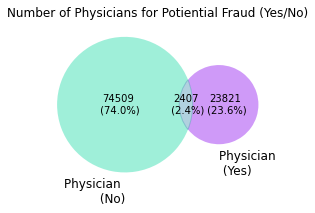

In [73]:
df=physicians[['Physician','ClaimID','PotentialFraud']].groupby(['Physician','PotentialFraud']).count().reset_index()
summary_venn(df, 'Physician', 'PotentialFraud',  title='Number of Physicians for Potiential Fraud (Yes/No)')

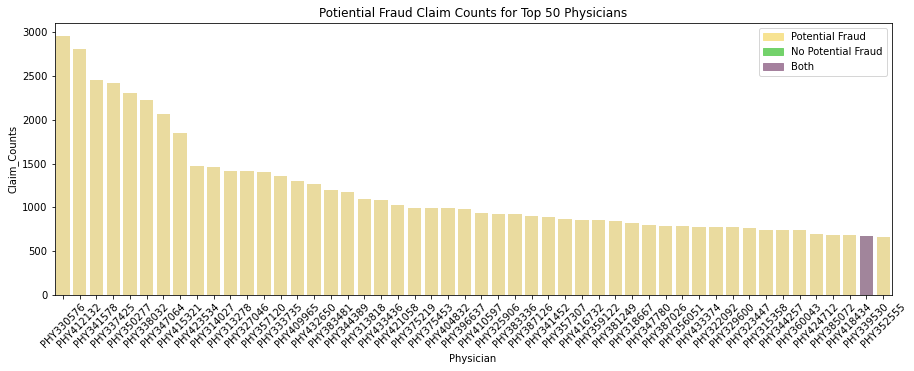

In [74]:
df=physicians[['Physician','ClaimID','PotentialFraud']].groupby(['Physician','PotentialFraud']).count().reset_index()
df1=df[df['PotentialFraud']=='Yes'].sort_values(by='ClaimID', ascending=False)
df2=df[df['PotentialFraud']=='No'].sort_values(by='ClaimID', ascending=False)

df11=pd.merge(df1['Physician'].head(50), df2, on='Physician', how='left')
df11['PotentialFraud']=df11['PotentialFraud'].fillna('No')
df11['ClaimID']=df11['ClaimID'].fillna(0)
df11=pd.concat([df1.head(50), df11])

df22=pd.merge(df2['Physician'].head(50), df1, on='Physician', how='left')
df22['PotentialFraud']=df22['PotentialFraud'].fillna('Yes')
df22['ClaimID']=df22['ClaimID'].fillna(0)
df22=pd.concat([df2.head(50), df22])

df1.rename(columns={'ClaimID':'Claim_Counts'}, inplace=True)
df1=pd.merge(df1, df_all, on='Physician', how='left').head(50)

bar_by_category(df1, 'Physician', 'Claim_Counts', 'IsPhysicianFraud', 
                title='Potiential Fraud Claim Counts for Top 50 Physicians')

Number of Physician (total) :  100737
Nuber of Physician (No Only) :  74509 (74.0% )
Nuber of Physician (Yes Only) :  23821 (23.6% )
Number of Physician (Both): 2407 (2.4% )


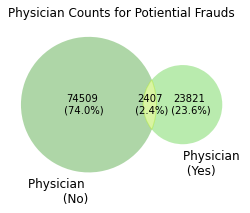

In [76]:
summary_venn(df, 'Physician', 'PotentialFraud', 
             title='Physician Counts for Potiential Frauds')

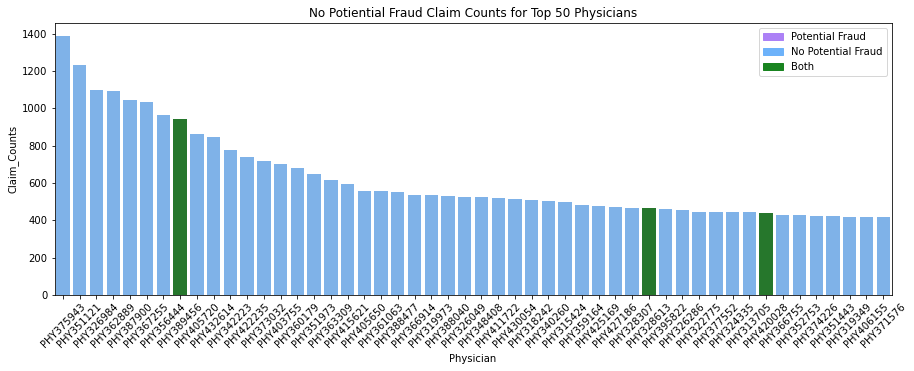

In [77]:

df2.rename(columns={'ClaimID':'Claim_Counts'}, inplace=True)
df=pd.merge(df2, df_all, on='Physician', how='left').head(50)

bar_by_category(df, 'Physician', 'Claim_Counts', 'IsPhysicianFraud', 
                title='No Potiential Fraud Claim Counts for Top 50 Physicians')


Text(0.5, 1.0, 'Most Potiential Fraud Claim Counts for Top 50 Physicians')

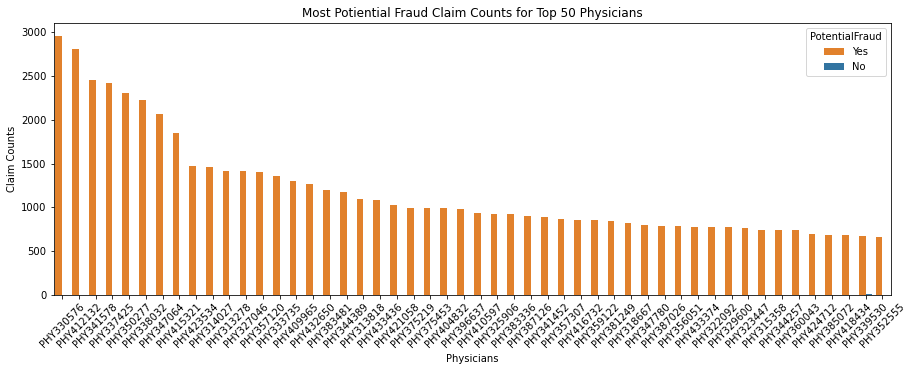

In [78]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = 'Physician', y = 'ClaimID', hue='PotentialFraud',
                 ci=None, palette=["C1", "C0", "k"],
                 data = df11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Physicians')
ax.set_ylabel('Claim Counts')

ax.set_title('Most Potiential Fraud Claim Counts for Top 50 Physicians')

Text(0.5, 1.0, 'Most No Suspective Claim Counts for Top 50 Physicians')

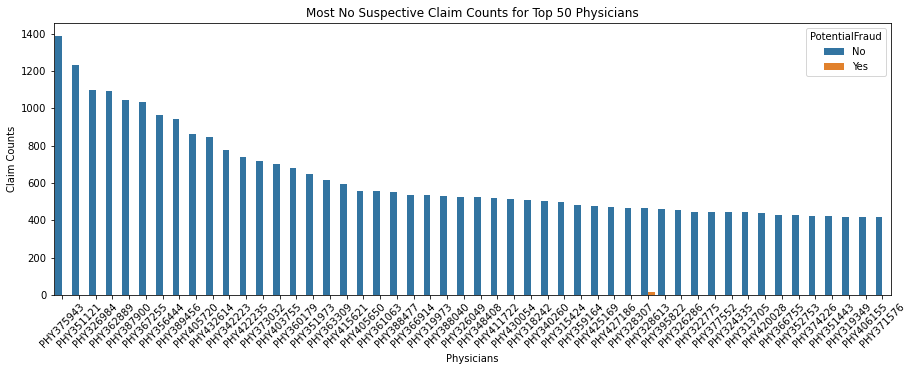

In [79]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = 'Physician', y = 'ClaimID', hue='PotentialFraud',
                 ci=None, palette=["C0", "C1", "k"],
                 data = df22)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Physicians')
ax.set_ylabel('Claim Counts')

ax.set_title('Most No Suspective Claim Counts for Top 50 Physicians')

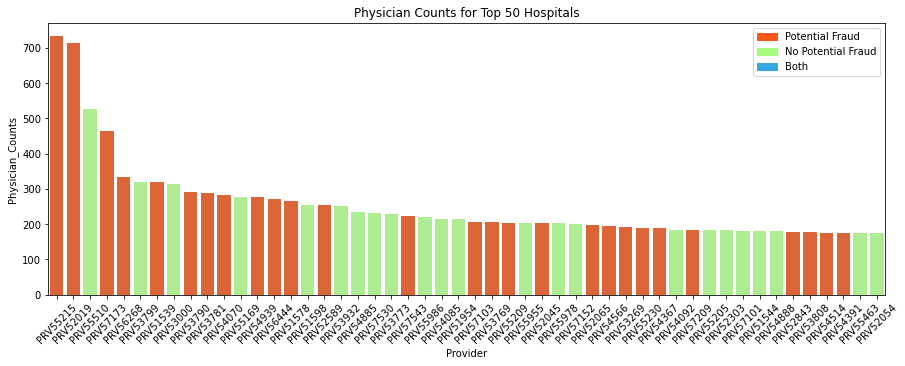

In [80]:
df=physicians[['Physician','Provider', 'PotentialFraud']].drop_duplicates() \
    .groupby(['Provider', 'PotentialFraud']).count().reset_index().sort_values(by='Physician', ascending=False)


df=df.rename(columns={'Physician':'Physician_Counts'}).head(50)


bar_by_category(df, 'Provider', 'Physician_Counts', 'PotentialFraud', 
                title='Physician Counts for Top 50 Hospitals')


<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Number of Physicians (total) :  100737</font> </li>
    <li> <font color='red'>Nuber of Physicians (Potential Fraud Only) :  23821</font> </li>
    <li> <font color='red'>Nuber of Physicians (No Potential Fraud Only) :  74509</font> </li>
    <li> <font color='red'>Number of Physicians (Both): 2407</font> </li>
    <li> <font color='red'>The top physicians who have most claims related to potential fraud hospitals usually are not associated with any providers without potential fraud.</font> </li>
    <li> <font color='red'>On the contrary, the top physicians who have most claims related to no potential fraud hospitals usually are not associated with any providers with potential frauds.</font> </li>
    
</div>

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Patients</h1>

In [81]:
patients=train[['BeneID', 'ClaimID', 'Provider', 'PotentialFraud', 
              'Category', 'DOB', 'Gender', 'Race', 'State', 'County']]

#### Age

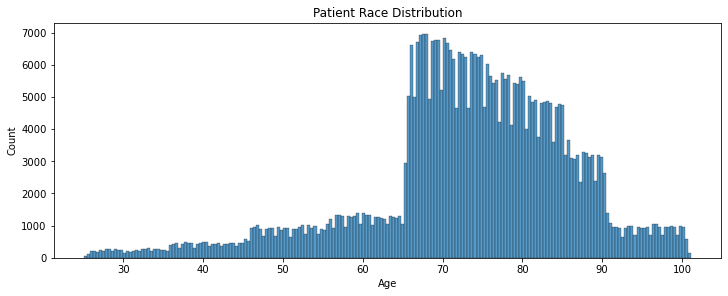

In [82]:
df=train[['BeneID', 'Age', 'Age_group']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.histplot(x="Age", data=df)
plt.title('Patient Race Distribution')
plt.show()

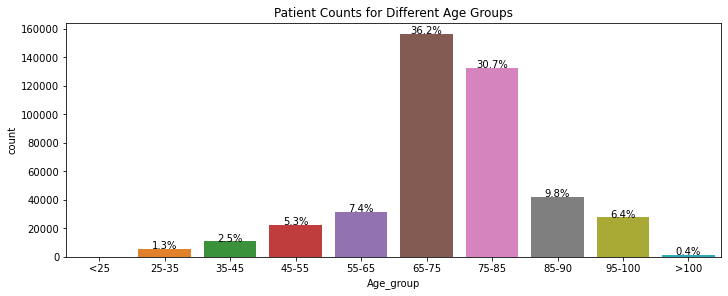

In [83]:
df=train[['BeneID', 'Age', 'Age_group']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.countplot(x="Age_group",  data=df)
annote_bars(df, 'Age_group', 10, note_type='percentage',ax=ax)
plt.title('Patient Counts for Different Age Groups')
plt.show()

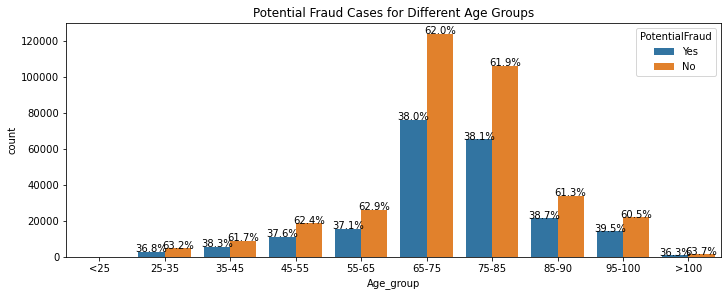

In [84]:
df=train[['BeneID', 'ClaimID', 'Age', 'Age_group','PotentialFraud']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.countplot(x="Age_group", hue='PotentialFraud', data=df)
annote_bars(df, 'Age_group', 10, hue_feature='PotentialFraud', note_type='percentage',ax=ax)
plt.title('Potential Fraud Cases for Different Age Groups')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Age can be divided into 10-year interval groups, each group have similar pattern of claim counts.</font> </li>
    <li> <font color='red'>Patients between 65-75 makes the most claims.</font> </li>
    <li> <font color='red'>Patients before 25 makes the least claims. </font> </li>
    <li> <font color='red'>The percentage of committing potential frauds for each group are similar, that is about 36% - 38%.</font> </li>
    
</div>

#### Race

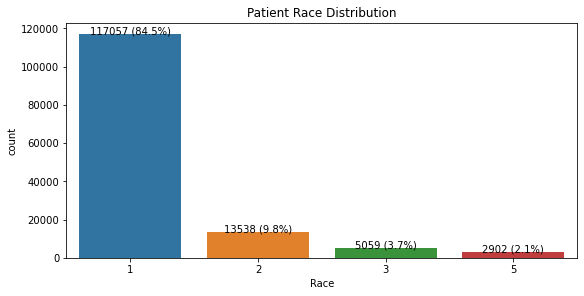

In [85]:
df=train[['BeneID', 'Race']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(8,4))
ax=sns.countplot(x="Race", data=df)
annote_bars(df, 'Race', 4, hue_feature=None, note_type='count_percentage',ax=ax)
plt.title('Patient Race Distribution')
plt.show()

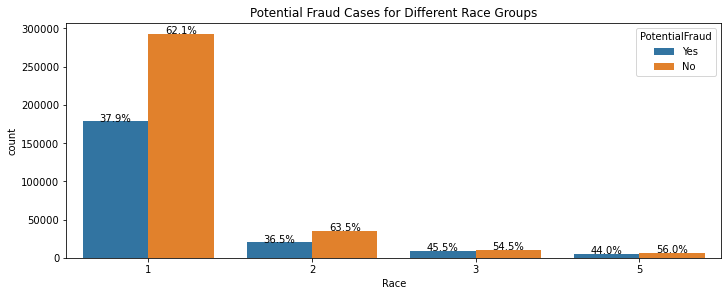

In [86]:
df=train[['BeneID', 'ClaimID', 'Race','PotentialFraud']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.countplot(x="Race", hue='PotentialFraud', data=df)
annote_bars(df, 'Race', 4, hue_feature='PotentialFraud', note_type='percentage',ax=ax)
plt.title('Potential Fraud Cases for Different Race Groups')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Race 1 has the most claim counts(117057) and Race 5 has the least claim counts(2902).</font> </li>
    <li> <font color='red'>Race 3 and Race 5 have the most percentage of claims with potential Fraud.</font> </li>
    <li> <font color='red'>Race 1 and Race 2 have the least percentage of claims with potential Frauds.</font> </li>    
</div>

#### Gender

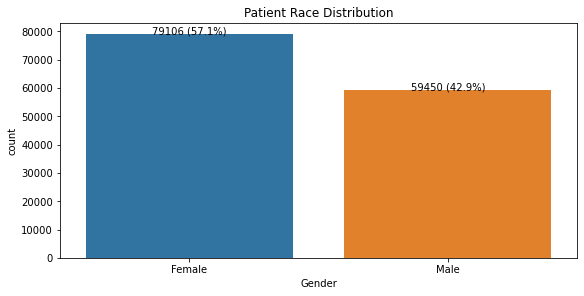

In [87]:
df=train[['BeneID', 'Gender']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(8,4))
ax=sns.countplot(x="Gender", data=df)
annote_bars(df, 'Gender', 2, hue_feature=None, note_type='count_percentage',ax=ax)
plt.title('Patient Race Distribution')
plt.show()

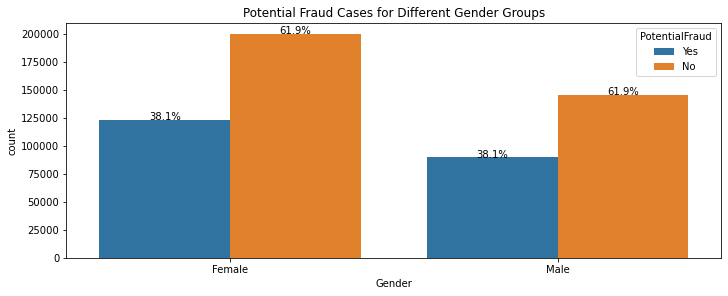

In [88]:
df=train[['BeneID', 'ClaimID', 'Gender','PotentialFraud']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.countplot(x="Gender", hue='PotentialFraud', data=df)
annote_bars(df, 'Gender', 2, hue_feature='PotentialFraud', note_type='percentage',ax=ax)
plt.title('Potential Fraud Cases for Different Gender Groups')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Females have more claim counts(79106) than males (59450).</font> </li>
    <li> <font color='red'>The percentage of claims with potential Frauds are similar between females and males.</font> </li>    
</div>

#### State

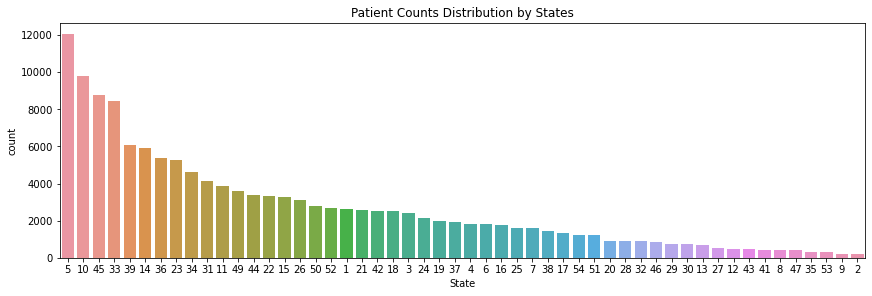

In [89]:
df=train[['BeneID', 'State']].drop_duplicates()
fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="State",
            order = df['State'].value_counts().index,
            data=df)
# annote_bars(df, 'State', 2, hue_feature=None, 
#             note_type='count_percentage',ax=ax)
plt.title('Patient Counts Distribution by States')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>State 5 has the most patients.</font> </li>
</div>

5


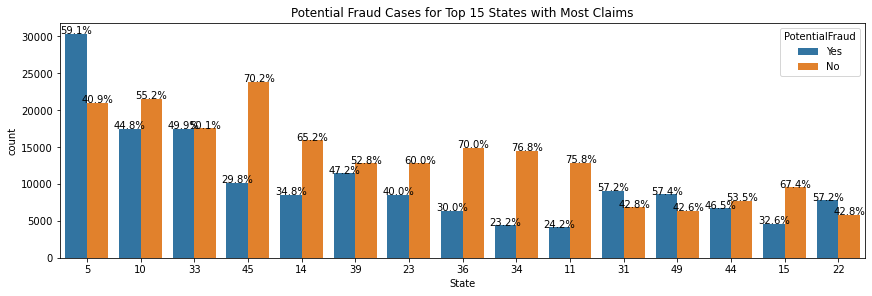

In [90]:
df=train[['BeneID', 'ClaimID', 'State','PotentialFraud']].drop_duplicates()
state_index=df['State'].value_counts().index.tolist()[:15]
df=df[df['State'].isin(state_index)]

# sort df by top state 
sorterIndex = dict(zip(state_index, range(len(state_index))))
df['State_rank'] = df['State'].map(sorterIndex)
df.sort_values(['State_rank'], inplace = True)
df['State']=df['State'].astype(str) 
df.drop('State_rank', 1, inplace = True)
# plot the top 15 states with most potential frauds
fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="State",
            hue='PotentialFraud', 
            data=df)
annote_bars1(df, 'State', 15, hue_feature='PotentialFraud', note_type='percentage',ax=ax, sorterindex=state_index)
plt.title('Potential Fraud Cases for Top 15 States with Most Claims')
plt.show()

5


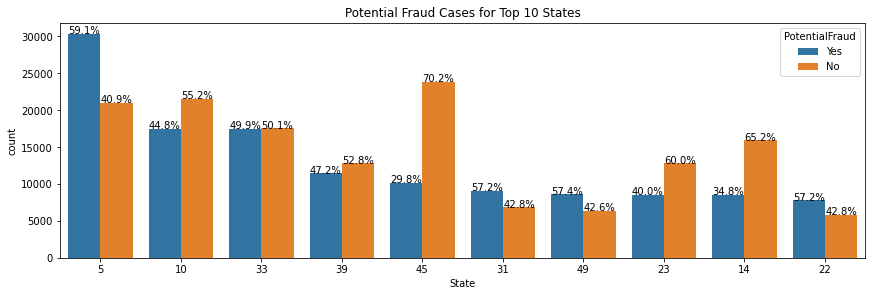

In [91]:
df=train[['BeneID', 'ClaimID', 'State','PotentialFraud']].drop_duplicates()
df1=df[df['PotentialFraud']=='Yes']
state_index=df1['State'].value_counts().index.tolist()[:10]
df=df[df['State'].isin(state_index)]

# sort df by top state 
sorterIndex = dict(zip(state_index, range(len(state_index))))
df['State_rank'] = df['State'].map(sorterIndex)
df.sort_values(['State_rank'], inplace = True)
df['State']=df['State'].astype(str) 
df.drop('State_rank', 1, inplace = True)

fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="State",
            hue='PotentialFraud', data=df)
annote_bars1(df, 'State', 10, hue_feature='PotentialFraud', note_type='percentage',ax=ax, sorterindex=state_index)
plt.title('Potential Fraud Cases for Top 10 States')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>State 5 has the most potential fraud claims.</font> </li>
</div>

46


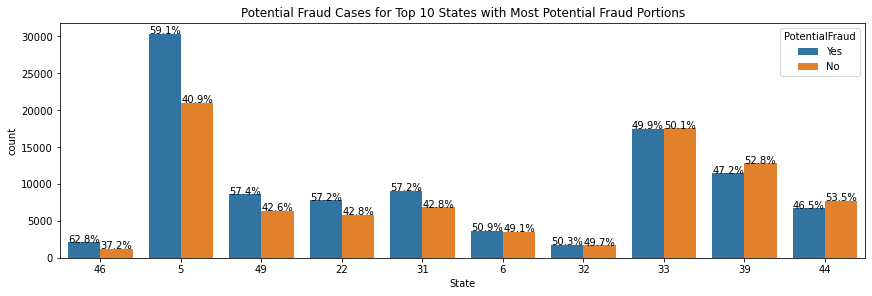

In [92]:
df=train[['BeneID', 'ClaimID', 'State','PotentialFraud']].drop_duplicates()
df1=df[df['PotentialFraud']=='Yes'].groupby(['State','PotentialFraud']).count().reset_index()
df2=df[df['PotentialFraud']=='No'].groupby(['State','PotentialFraud']).count().reset_index()
df3=pd.merge(df1,df2,on=['State'], how='outer')
df3['percentage']=df3['ClaimID_x']/(df3['ClaimID_x']+df3['ClaimID_y'])
df3=df3.sort_values(by='percentage',ascending=False)
state_index=df3['State'].head(10).tolist()
df=df[df['State'].isin(state_index)]

# sort df by top state 
sorterIndex = dict(zip(state_index, range(len(state_index))))
df['State_rank'] = df['State'].map(sorterIndex)
df.sort_values(['State_rank'], inplace = True)
df['State']=df['State'].astype(str) 
df.drop('State_rank', 1, inplace = True)

fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="State",
            hue='PotentialFraud', data=df)
annote_bars1(df, 'State', 10, hue_feature='PotentialFraud', note_type='percentage',ax=ax, sorterindex=state_index)
plt.title('Potential Fraud Cases for Top 10 States with Most Potential Fraud Portions')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>State 46 has the most percentage of potential fraud claims, which is 62.8%.</font> </li>
    <li> <font color='red'>7 states have over 50% claims which are potential fraud claims</font> </li>    
</div>

#### County

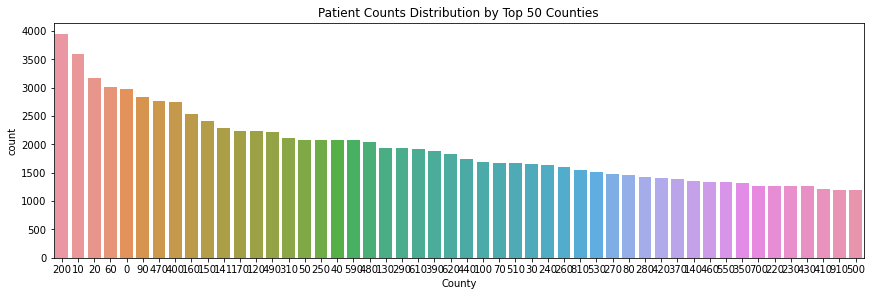

In [93]:
df=train[['BeneID', 'County']].drop_duplicates()
county_index=df.groupby('County').count().sort_values(by='BeneID',ascending=False).reset_index()['County']
df=df[df['County'].isin(county_index[:50])]
fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="County",
            order = df['County'].value_counts().index,
            data=df)
# annote_bars(df, 'State', 2, hue_feature=None, 
#             note_type='count_percentage',ax=ax)
plt.title('Patient Counts Distribution by Top 50 Counties')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>County 600, 10 and 20 have most patients who submitted claims.</font> </li>
</div>

200


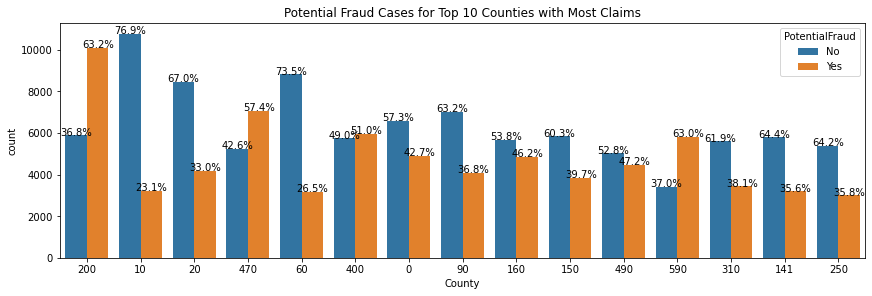

In [94]:
df=train[['BeneID', 'ClaimID', 'County','PotentialFraud']].drop_duplicates()
county_index=df['County'].value_counts().index.tolist()[:15]
df=df[df['County'].isin(county_index)]

# sort df by top state 
sorterIndex = dict(zip(county_index, range(len(county_index))))
df['County_rank'] = df['County'].map(sorterIndex)
df.sort_values(['County_rank'], inplace = True)
df['County']=df['County'].astype(str) 
df.drop('County_rank', 1, inplace = True)
# plot the top 15 states with most potential frauds
fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="County",
            hue='PotentialFraud', 
            data=df)
annote_bars1(df, 'County', 15, hue_feature='PotentialFraud', note_type='percentage',ax=ax, sorterindex=county_index)
plt.title('Potential Fraud Cases for Top 10 Counties with Most Claims')
plt.show()

891


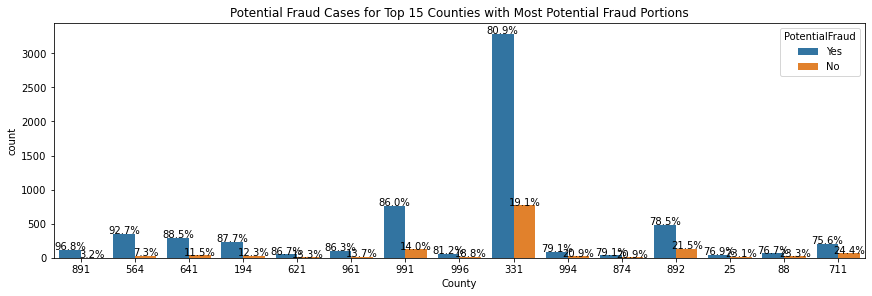

In [95]:
df=train[['BeneID', 'ClaimID', 'County','PotentialFraud']].drop_duplicates()
df1=df[df['PotentialFraud']=='Yes'].groupby(['County','PotentialFraud']).count().reset_index()
df2=df[df['PotentialFraud']=='No'].groupby(['County','PotentialFraud']).count().reset_index()
df3=pd.merge(df1,df2,on=['County'], how='outer')
df3['percentage']=df3['ClaimID_x']/(df3['ClaimID_x']+df3['ClaimID_y'])
df3=df3.sort_values(by='percentage',ascending=False)
county_index=df3['County'].head(15).tolist()
df=df[df['County'].isin(county_index)]

# sort df by top state 
sorterIndex = dict(zip(county_index, range(len(county_index))))
df['County_rank'] = df['County'].map(sorterIndex)
df.sort_values(['County_rank'], inplace = True)
df['County']=df['County'].astype(str) 
df.drop('County_rank', 1, inplace = True)

fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="County",
            hue='PotentialFraud', data=df)
annote_bars1(df, 'County', 15, hue_feature='PotentialFraud', note_type='percentage',ax=ax, sorterindex=county_index)
plt.title('Potential Fraud Cases for Top 15 Counties with Most Potential Fraud Portions')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Count 891, 564, and 641 have the most percentage of claims which are potential frauds.</font> </li>
</div>

#### Hospital

Text(0.5, 1.0, 'Hospital Visited for Top 50 Patients')

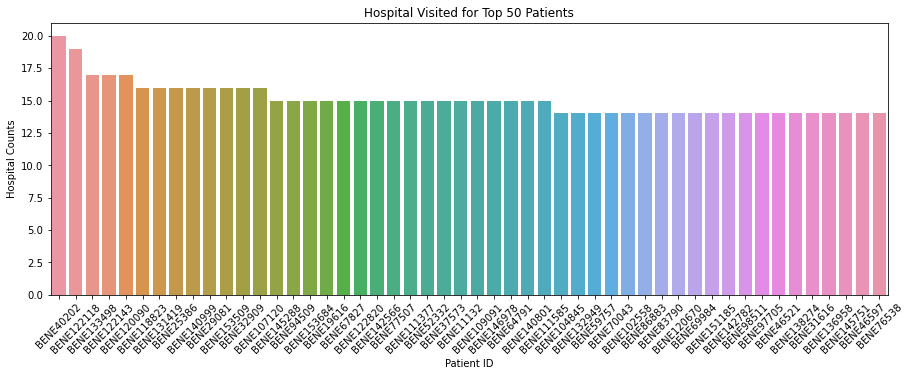

In [96]:
df=patients[['BeneID','Provider']].drop_duplicates().groupby('BeneID').count().reset_index().sort_values(by='Provider', ascending=False)

plt.figure(figsize=(15,5))
ax = sns.barplot(x = 'BeneID', y = 'Provider',data = df.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Patient ID')
ax.set_ylabel('Hospital Counts')

ax.set_title('Hospital Visited for Top 50 Patients')

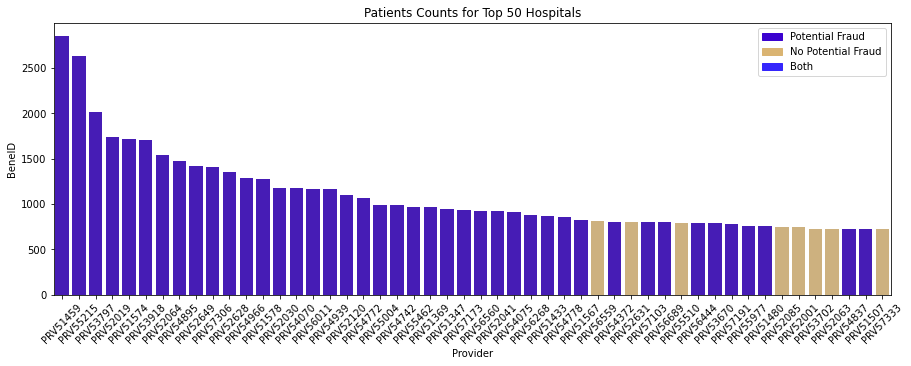

In [97]:
df=patients[['BeneID','Provider', 'PotentialFraud']].drop_duplicates() \
    .groupby(['Provider', 'PotentialFraud']).count().reset_index().sort_values(by='BeneID', ascending=False)

top_provider=df.head(50)
bar_by_category(top_provider, 'Provider', 'BeneID', 'PotentialFraud', title='Patients Counts for Top 50 Hospitals')

In [98]:
df.head(50)

,Provider,PotentialFraud,BeneID
363,PRV51459,Yes,2857
3363,PRV55215,Yes,2638
2250,PRV53797,Yes,2020
818,PRV52019,Yes,1734
455,PRV51574,Yes,1715
2335,PRV53918,Yes,1709
853,PRV52064,Yes,1536
3113,PRV54895,Yes,1469
1325,PRV52649,Yes,1421
5032,PRV57306,Yes,1407


In [99]:
df[df['BeneID']<10]['PotentialFraud'].isin(['Yes']).any()

True

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Patient Bene40202 visited the most hospitals (20)</font> </li>
    <li> <font color='red'>PRV51459 have the most patients</font> </li>    
    <li> <font color='red'>Top 30 providers with most patients are suspects of potential frauds</font> </li> 
    <li> <font color='red'>All providers which have over 1000 patients who make claims are suspective of potential frauds</font> </li>    
</div>

#### Claims

Text(0.5, 1.0, 'Claim Counts for Top 50 Patients')

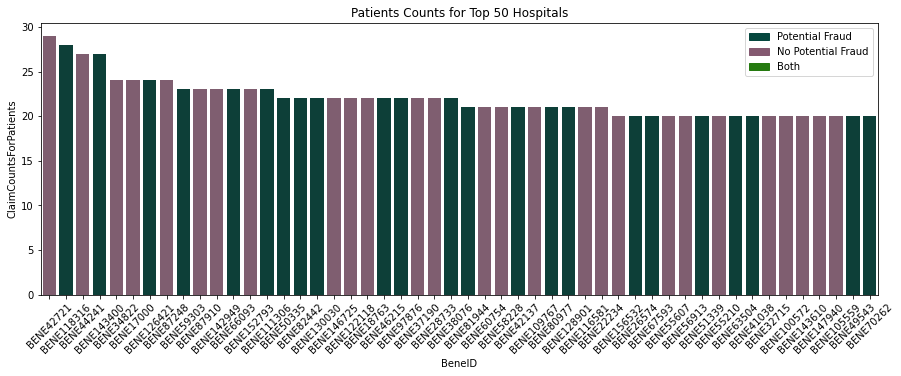

In [100]:
df=train[['ClaimID','BeneID', 'PotentialFraud']].drop_duplicates() \
    .groupby(['BeneID', 'PotentialFraud']).count().reset_index() \
    .rename( columns={'ClaimID':'ClaimCountsForPatients'}).sort_values(by='ClaimCountsForPatients', ascending=False)

top_provider=df.head(50)
bar_by_category(top_provider, 'BeneID', 'ClaimCountsForPatients', 'PotentialFraud', title='Patients Counts for Top 50 Hospitals')

ax.set_title('Claim Counts for Top 50 Patients')

#### Physicians

Text(0.5, 1.0, 'Physician Counts for Top 50 Patients')

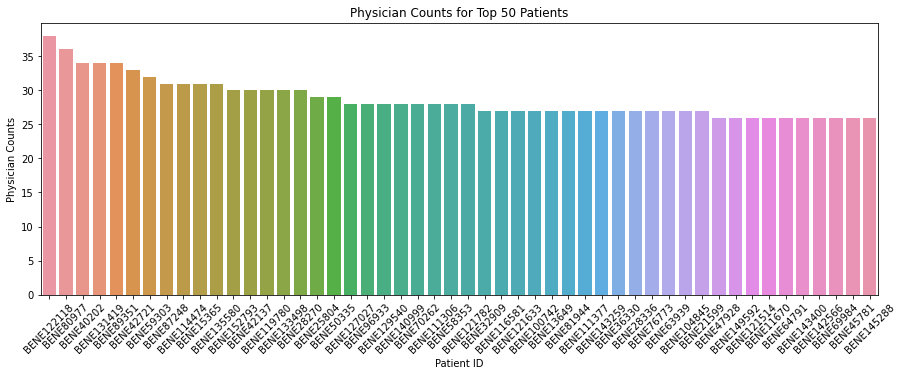

In [101]:
df=physicians[['Physician','BeneID']].drop_duplicates() \
    .groupby(['BeneID']).count().reset_index() \
    .rename( columns={'Physician':'PhysicianCountsForPatients'}).sort_values(by='PhysicianCountsForPatients', ascending=False)

plt.figure(figsize=(15,5))
ax = sns.barplot(x = 'BeneID', y = 'PhysicianCountsForPatients',data = df.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Patient ID')
ax.set_ylabel('Physician Counts')

ax.set_title('Physician Counts for Top 50 Patients')

#### Fraud

Number of BeneID (total) :  138556
Nuber of BeneID (Yes Only) :  24929 (18.0% )
Nuber of BeneID (No Only) :  54559 (39.4% )
Number of BeneID (Both): 59068 (42.6% )


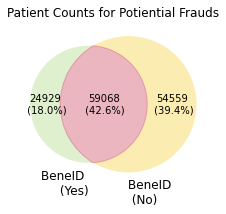

In [103]:
df=patients.groupby(['BeneID','PotentialFraud']).count().reset_index()

summary_venn(df, 'BeneID', 'PotentialFraud', 
             title='Patient Counts for Potiential Frauds')

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Number of Patients (total) :  138556</font> </li>
    <li> <font color='red'>Nuber of Patients (Only have potential fraud claims) :  24929</font> </li>    
    <li> <font color='red'>Nuber of Patients (Only have non-potential fraud claims) :  54559</font> </li>     
    <li> <font color='red'>Number of Patients (Both): 59068</font> </li>    
</div>

#### Inpatient / Outpatient

Number of BeneID (total) :  138556
Nuber of BeneID (Outpatient Only) :  107267 (77.4% )
Nuber of BeneID (Inpatient Only) :  4576 (3.3% )
Number of BeneID (Both): 26713 (19.3% )


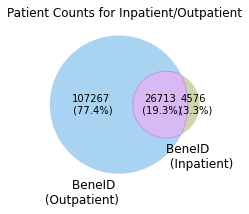

In [106]:
df=patients.groupby(['BeneID','Category']).count().reset_index()

summary_venn(df, 'BeneID', 'Category', 
             title='Patient Counts for Inpatient/Outpatient')

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Number of Patients (total) :  138556</font> </li>
    <li> <font color='red'>Nuber of Patients (Only have Inpatient service) :  4576</font> </li>    
    <li> <font color='red'>Nuber of Patients (Only have Outpatient service) :  107267</font> </li>     
    <li> <font color='red'>Number of Patients (Both): 26713</font> </li>    
</div>

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Age</h1>

#### Age Groups

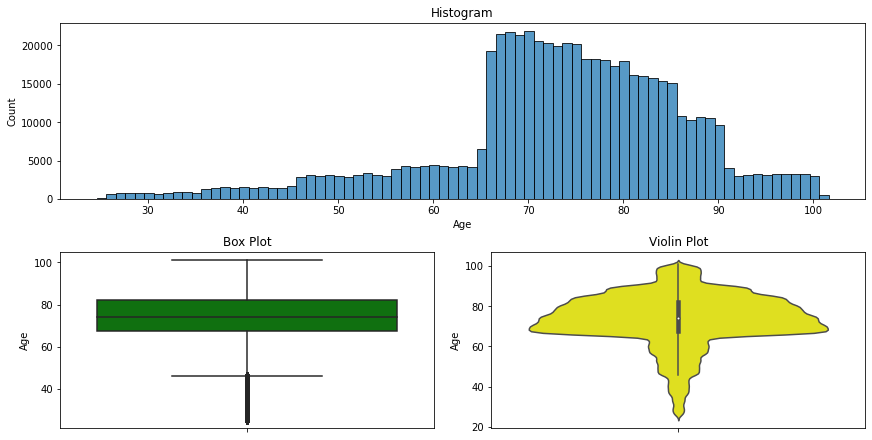

In [107]:
uni_distplot(train, 'Age')

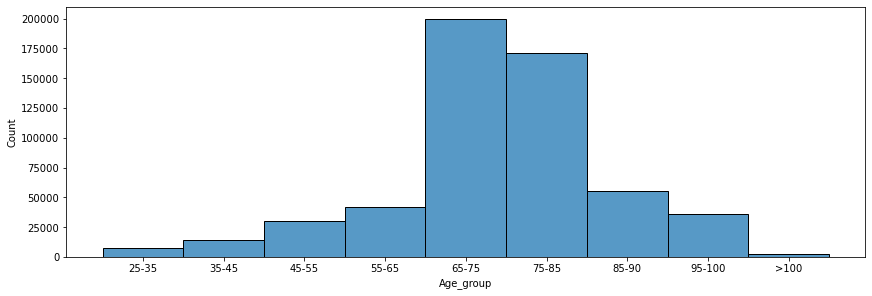

In [108]:
fig = plt.figure(constrained_layout=True, figsize=(12,4))
sns.histplot(x="Age_group", data=train)
plt.show()

#### Chronic conditions

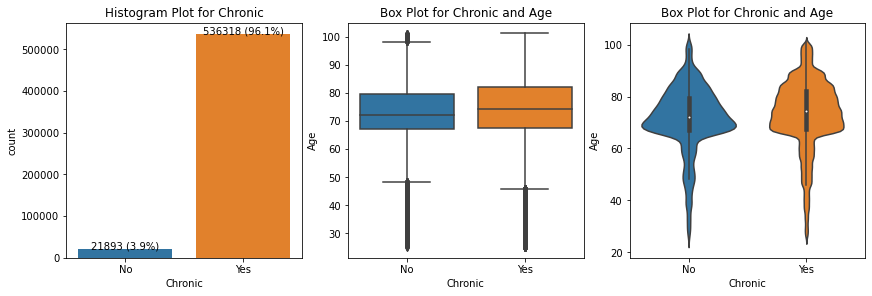

In [109]:
bi_distplot(train, 'Chronic', 'Age', 'Gender')

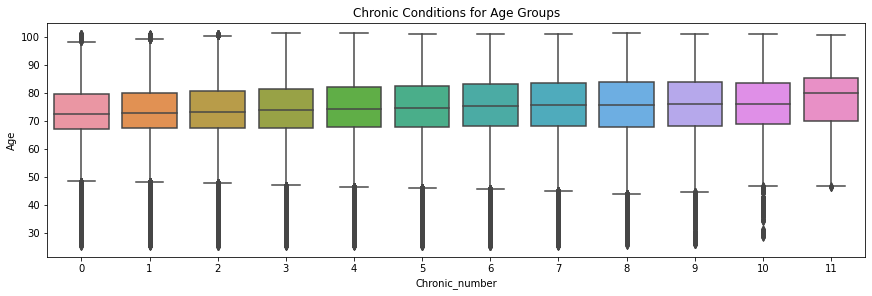

In [110]:
fig = plt.figure(constrained_layout=True, figsize=(12,4))
sns.boxplot(x ='Chronic_number', y ='Age', data = train)
plt.title('Chronic Conditions for Age Groups')
plt.show()

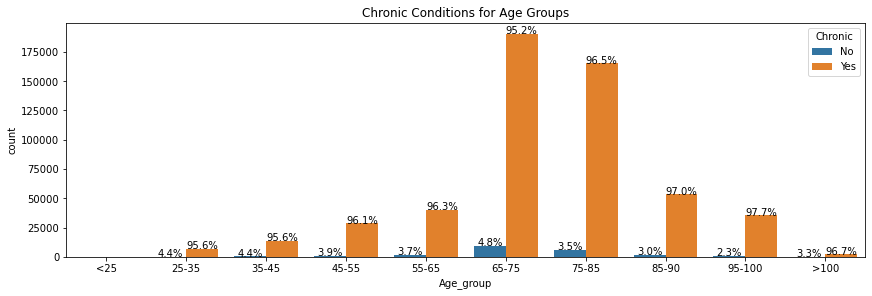

In [111]:
fig = plt.figure(constrained_layout=True, figsize=(12,4))
ax=sns.countplot(x="Age_group", hue='Chronic',  data=train)
annote_bars(train, 'Age_group', 10, hue_feature='Chronic', note_type='percentage',ax=ax)
plt.title('Chronic Conditions for Age Groups')
plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Most patients have chronic diseases</font> </li>
    <li> <font color='red'>The percentage of having chronic diseases are not obviously different among age groups</font> </li>   
</div>

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Chronic Diseases</h1>

#### distribution

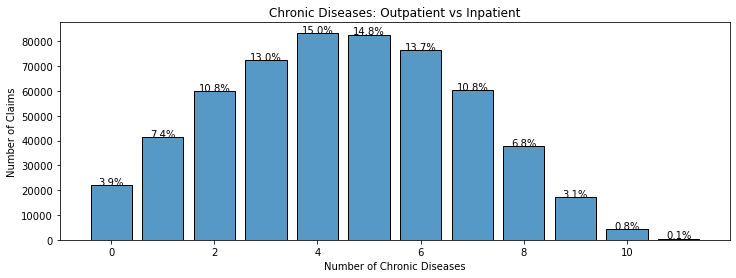

In [112]:
plt.figure(figsize=(12,4))
ax=sns.histplot(x='Chronic_number',
            data=train,
            discrete=True,
            shrink=0.8,
            palette = "Spectral_r")
plt.xlabel('Number of Chronic Diseases')
plt.ylabel('Number of Claims')
plt.title('Chronic Diseases: Outpatient vs Inpatient')
annote_bars(train, 'Chronic_number', 12, note_type='percentage', ax=ax)

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Most patients have 2-8 chronic diseases.</font> </li>
    <li> <font color='red'>The chronic disease counts are normally distributed as to the claim counts. </font> </li>
</div>

#### Inpatient / Outpatient

Text(0.5, 1.0, 'Chronic Diseases: Outpatient vs Inpatient')

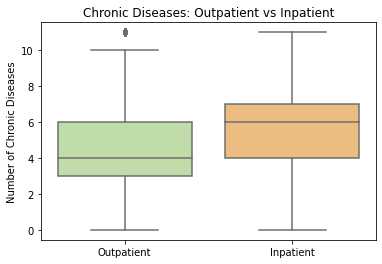

In [114]:
plt.figure(figsize=(6,4))
ax=sns.boxplot(x='Category',
            y='Chronic_number',
            data=train,
            palette = "Spectral_r")
plt.xlabel('')
plt.ylabel('Number of Chronic Diseases')
plt.title('Chronic Diseases: Outpatient vs Inpatient')

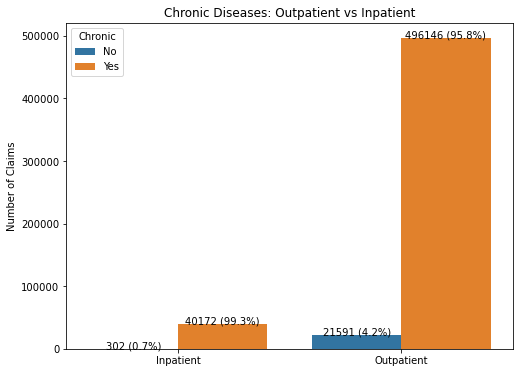

In [113]:
plt.figure(figsize=(8,6))
ax=sns.countplot(x='Category',
            hue='Chronic',
            order = train['Category'].value_counts().index.sort_values(),
            data=train)
plt.xlabel('')
plt.ylabel('Number of Claims')
plt.title('Chronic Diseases: Outpatient vs Inpatient')

annote_bars(train, 'Category', 2, 'Chronic', note_type='count_percentage', ax=ax)
plt.show()

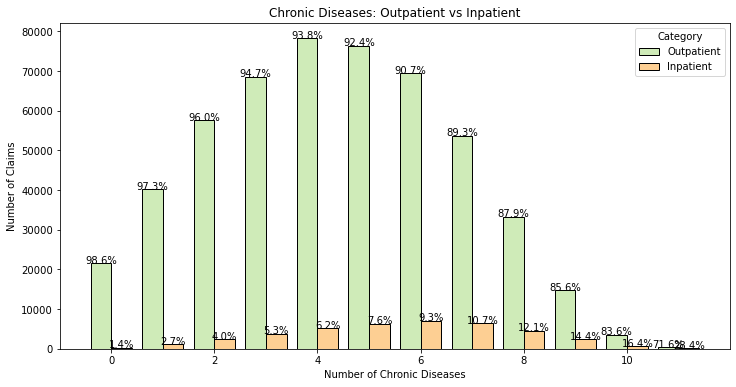

In [115]:
plt.figure(figsize=(12,6))
ax=sns.histplot(x='Chronic_number',
               hue='Category',
               data=train,
               discrete=True, 
               shrink=0.8,
               multiple="dodge", 
               palette = "Spectral_r")
plt.xlabel('Number of Chronic Diseases')
plt.ylabel('Number of Claims')
plt.title('Chronic Diseases: Outpatient vs Inpatient')
annote_bars(train, 'Chronic_number', 12, 'Category', note_type='percentage', ax=ax)

plt.show()

<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>Inpatient patients have a higher median value of chronic diseases counts. </font> </li>
    <li> <font color='red'>99% inpatient patients have chronic diseases, while 95% outpatient patients have chronic diseases. </font> </li>
    <li> <font color='red'>The percentage of claims from inpatient patients increases as the number of chronic diseases increase. </font> </li>
</div>

#### Potential Fraud

Text(0.5, 1.0, 'Chronic Diseases: Potential Fraud')

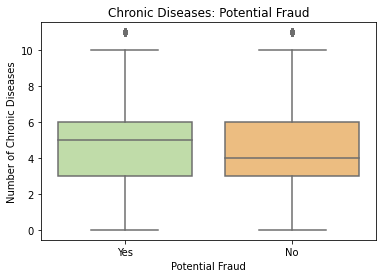

In [116]:
plt.figure(figsize=(6,4))
ax=sns.boxplot(x='PotentialFraud',
            y='Chronic_number',
            data=train,
            palette = "Spectral_r")
plt.xlabel('Potential Fraud')
plt.ylabel('Number of Chronic Diseases')
plt.title('Chronic Diseases: Potential Fraud')

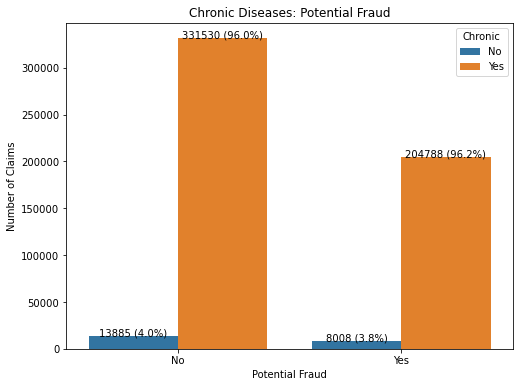

In [117]:
plt.figure(figsize=(8,6))
ax=sns.countplot(x='PotentialFraud',
            hue='Chronic',
            order = train['PotentialFraud'].value_counts().index.sort_values(),
            data=train)
plt.xlabel('Potential Fraud')
plt.ylabel('Number of Claims')
plt.title('Chronic Diseases: Potential Fraud')

annote_bars(train, 'PotentialFraud', 2, 'Chronic', note_type='count_percentage', ax=ax)
plt.show()

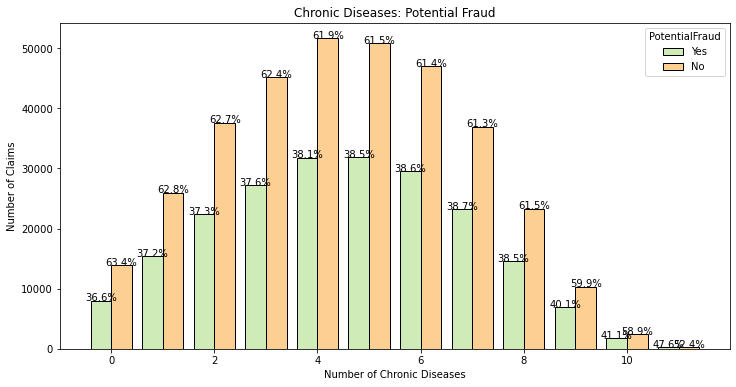

In [119]:
plt.figure(figsize=(12,6))
ax=sns.histplot(x='Chronic_number',
               hue='PotentialFraud',
               data=train,
               discrete=True, 
               bins=12,
               shrink=.8,
               multiple="dodge", 
               palette = "Spectral_r")
plt.xlabel('Number of Chronic Diseases')
plt.ylabel('Number of Claims')
plt.title('Chronic Diseases: Potential Fraud')

annote_bars(train, 'Chronic_number', 12, 'PotentialFraud', note_type='percentage',ax=ax)
    
plt.show()


<div class="alert-warning">
    <b>Findings </b> 
    <li> <font color='red'>The median number of chronic disease for patients treated by suspective providers is higher than the median number of chronic disease for patients treated by non-suspective providers.  </font> </li>
    <li> <font color='red'>The average number of chronic diseases for patients treated by suspective and non-suspective providers are similar.</font> </li>
    <li> <font color='red'>For patients with different number of chronic diseases, there is not a big difference in the percentage of claims submitted by suspective or non-suspective providers.</font> </li>
    <li> <font color='red'>As the number of chronic diseases increases, for example patients with 9 or more chronic diseases, the percentage of claims from suspective providers will slightly increase to over 40%.</font> </li>
</div>